In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pickle
from scipy.stats import pearsonr, kruskal, chi2_contingency, randint, uniform
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from collections import defaultdict


bike_df = pd.read_csv('./files/bike_dataset_clean.csv')
bike_df.drop(columns='Unnamed: 0', inplace=True)

# check what the correlation between the different temperature features and total_cust is
# maybe I could just use one of the other temperature features instead of temp_avg

# correlation between temp_avg and total_cust
# The first 820 rows are excluded because they contain missing temp_avg values
print('temp_avg:', pearsonr(bike_df['temp_avg'][821:], bike_df['total_cust'][821:]), '\n')

# correlation between temp_min and total_cust
print('temp_min:', pearsonr(bike_df['temp_min'], bike_df['total_cust']))
print('temp_min, without first 820 rows:', pearsonr(bike_df['temp_min'][821:], bike_df['total_cust'][821:]), '\n')

# correlation between temp_max and total_cust
print('temp_max:', pearsonr(bike_df['temp_max'], bike_df['total_cust']))
print('temp_max, without first 820 rows:', pearsonr(bike_df['temp_max'][821:], bike_df['total_cust'][821:]), '\n')

# correlation between temp_observ and total_cust
print('temp_observ:', pearsonr(bike_df['temp_observ'], bike_df['total_cust']))
print('temp_observ, without first 820 rows:', pearsonr(bike_df['temp_observ'][821:], bike_df['total_cust'][821:]), '\n')

temp_avg: PearsonRResult(statistic=0.7289653483071338, pvalue=0.0) 

temp_min: PearsonRResult(statistic=0.5484063784007367, pvalue=3.92265728990609e-229)
temp_min, without first 820 rows: PearsonRResult(statistic=0.6720561174778342, pvalue=3.5204893405440216e-276) 

temp_max: PearsonRResult(statistic=0.5962507437902363, pvalue=6.986689659232709e-281)
temp_max, without first 820 rows: PearsonRResult(statistic=0.7406902128448435, pvalue=0.0) 

temp_observ: PearsonRResult(statistic=0.5500110613450737, pvalue=9.817169026462281e-231)
temp_observ, without first 820 rows: PearsonRResult(statistic=0.6804926361142358, pvalue=9.041087867799183e-286) 



In [2]:
# calculating the Granger causality between the temperature feats and the target
print('Average temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_avg']][821:], maxlag=1);
print('\nMaximum temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_max']], maxlag=1);
print('\nMinimum temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_min']], maxlag=1);
print('\nObserved temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_observ']], maxlag=1);

Average temperature and target:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=176.4496, p=0.0000  , df_denom=2097, df_num=1
ssr based chi2 test:   chi2=176.7020, p=0.0000  , df=1
likelihood ratio test: chi2=169.6602, p=0.0000  , df=1
parameter F test:         F=176.4496, p=0.0000  , df_denom=2097, df_num=1

Maximum temperature and target:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=40.0233 , p=0.0000  , df_denom=2918, df_num=1
ssr based chi2 test:   chi2=40.0645 , p=0.0000  , df=1
likelihood ratio test: chi2=39.7922 , p=0.0000  , df=1
parameter F test:         F=40.0233 , p=0.0000  , df_denom=2918, df_num=1

Minimum temperature and target:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=88.8911 , p=0.0000  , df_denom=2918, df_num=1
ssr based chi2 test:   chi2=88.9825 , p=0.0000  , df=1
likelihood ratio test: chi2=87.6540 , p=0.0000  , df=1
parameter F test:         F=88.8911 , p=0.0000  , df_denom=2918,

In [3]:
# function to create seasons for dataframe
def seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''

    #create a season features
    df['season_spring'] = df['date'].apply(lambda x: 1 if '01' in x[5:7] else 1 if '02' in x[5:7] else 1
                                                        if '03' in x[5:7] else 0)
    df['season_summer'] = df['date'].apply(lambda x: 1 if '04' in x[5:7] else 1 if '05' in x[5:7] else 1
                                                        if '06' in x[5:7] else 0)
    df['season_fall'] = df['date'].apply(lambda x: 1 if '07' in x[5:7] else 1 if '08' in x[5:7] else 1
                                                        if '09' in x[5:7] else 0)
    return df


In [4]:
# create new features for season
bike_df = seasons(bike_df)

# create new feature weekday
bike_df['date_datetime'] = bike_df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
bike_df['weekday'] = bike_df['date_datetime'].apply(lambda x: x.weekday())

# one hot encode the feature weekday
weekday_dummies = pd.get_dummies(bike_df['weekday'], prefix = 'weekday', drop_first=True)
bike_df = bike_df.join(weekday_dummies, how='left')
bike_df.head()

date  temp_avg  temp_min   temp_max  temp_observ    precip   wind  \
0  2011-01-01       NaN -1.566667  11.973333     2.772727  0.069333  2.575   
1  2011-01-02       NaN  0.880000  13.806667     7.327273  1.037349  3.925   
2  2011-01-03       NaN -3.442857   7.464286    -3.060000  1.878824  3.625   
3  2011-01-04       NaN -5.957143   4.642857    -3.100000  0.000000  1.800   
4  2011-01-05       NaN -4.293333   6.113333    -1.772727  0.000000  2.950   

   wt_fog  wt_heavy_fog  wt_thunder  ...  season_summer  season_fall  \
0     1.0           0.0         0.0  ...              0            0   
1     1.0           1.0         0.0  ...              0            0   
2     0.0           0.0         0.0  ...              0            0   
3     0.0           0.0         0.0  ...              0            0   
4     0.0           0.0         0.0  ...              0            0   

   date_datetime  weekday  weekday_1  weekday_2  weekday_3  weekday_4  \
0     2011-01-01        5          0          0          0          0   
1     2011-01-02        6          0          0          0          0   
2     2011-01-03        0          0          0          0          0   
3     2011-01-04        1          1          0          0          0   
4     2011-01-05        2          0          1          0          0   

   weekday_5  weekday_6  
0          1          0  
1          0          1  
2          0          0  
3          0          0  
4          0          0  

[5 rows x 40 columns]

In [5]:
#create new feature working_day
bike_df['working_day'] = bike_df['weekday'].apply(lambda x: 0 if x > 5 or x == 0 else 1)
bike_df['working_day'] = bike_df[['holiday', 'working_day']].apply( lambda x: 0 if x['holiday'] ==1 else
                                                                x['working_day'], axis=1)
#dropping date, registered and casual features because  this is in string format
bike_df.drop(columns=['date', 'temp_avg', 'registered', 'casual'], inplace=True)

Text(0, 0.5, 'Number of customers')

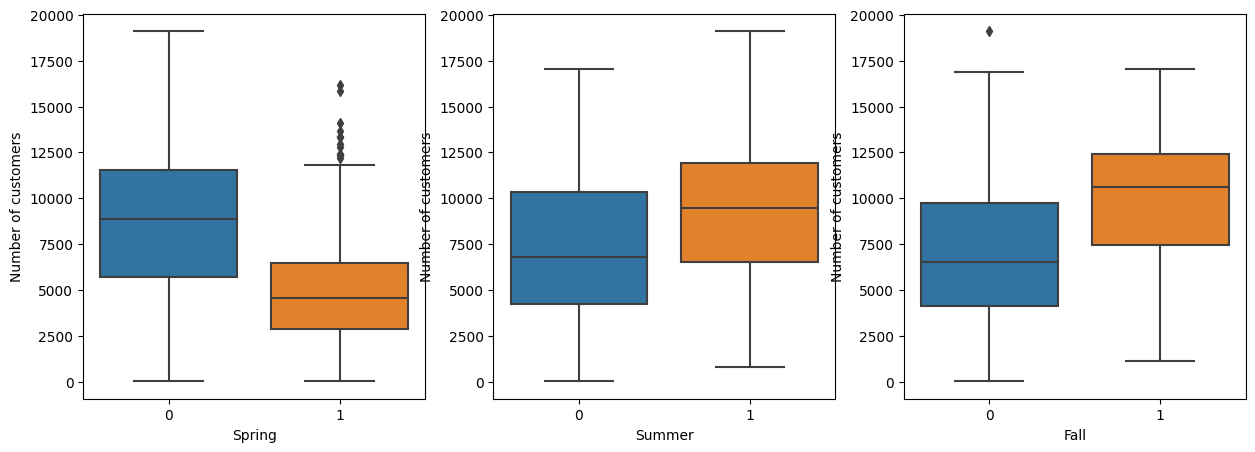

In [6]:
# Explorartory Data Analysis of Categorical Variables

# varialbe to be used below to iterate through the columns and plot them
season_names = ['season_spring', 'season_summer', 'season_fall']
# plot boxplots for season versus number of users
plt.figure(figsize = [15,5])

# boxplot for feature workingday
# spring
plt.subplot(1,3,1)
sb.boxplot(data=bike_df, x='season_spring', y='total_cust')
plt.xlabel('Spring')
plt.ylabel('Number of customers')

# boxplot for feature weekday
# summer
plt.subplot(1,3,2)
sb.boxplot(data=bike_df, x='season_summer',y='total_cust')
plt.xlabel('Summer')
plt.ylabel('Number of customers')

# boxplot for feature holiday
# fall
plt.subplot(1,3,3)
sb.boxplot(data=bike_df, x='season_fall',y='total_cust')
plt.xlabel('Fall')
plt.ylabel('Number of customers')

# these plots do not compare workingday vs weekday vs holiday! The are showing total customers across the seasons.

In [7]:
 #Correlation between seaon features and the maximum temperature using the
# Kruskal Wallis H test for correlation between a continuous and categorical variable
kruskal(bike_df['temp_max'], bike_df['season_summer'])

KruskalResult(statistic=4190.233791908425, pvalue=0.0)

<AxesSubplot: xlabel='holiday', ylabel='total_cust'>

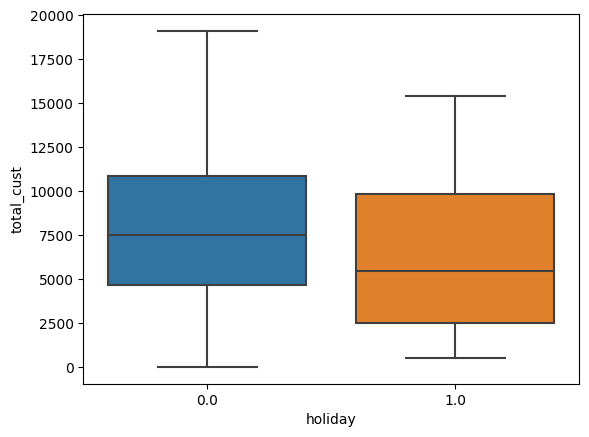

In [8]:
# plotting the customer statistics in form of a boxplot for the holiday feature
sb.boxplot(data=bike_df, x='holiday', y='total_cust')

In [9]:
# Correlation between holiday feature and the number of customers poer day using the
# Kurskal Wallis H test for correlations between a contiuous and categorical variable
kruskal(bike_df['holiday'], bike_df['total_cust'])

KruskalResult(statistic=4945.69275502358, pvalue=0.0)

Text(0, 0.5, 'Number of customers')

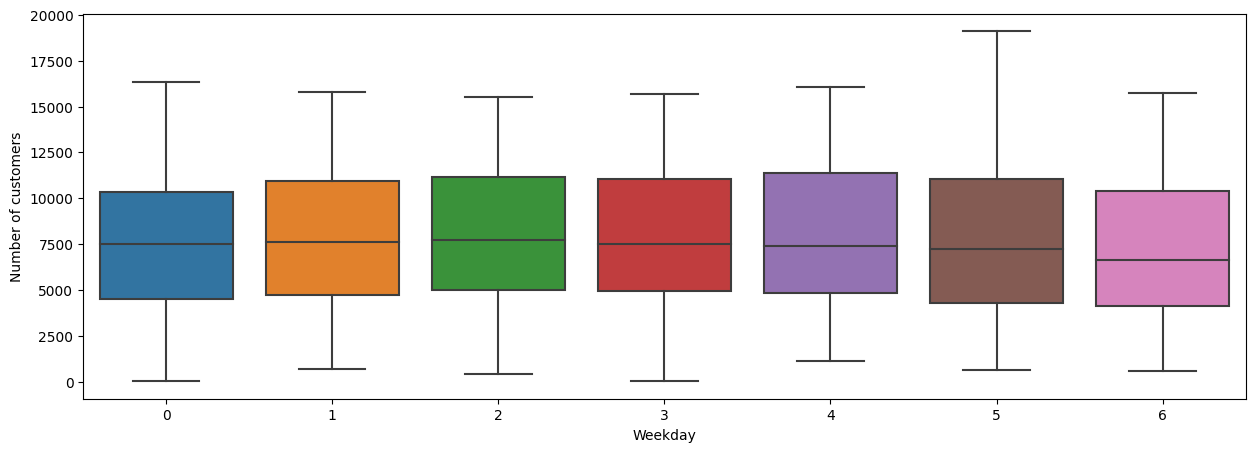

In [10]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize=[15,5])
sb.boxplot(data=bike_df, x='weekday', y='total_cust')
plt.xlabel('Weekday')
plt.ylabel('Number of customers')

In [11]:
# Correlation between weekday feature and the number of customers per day using Pearson's correlation coefficient
# assuming that a weekday can be considered a continuous variable.
pearsonr(bike_df['weekday'], bike_df['total_cust'])

PearsonRResult(statistic=-0.024760898572408853, pvalue=0.18086518739719304)

Text(0, 0.5, 'Number of customers')

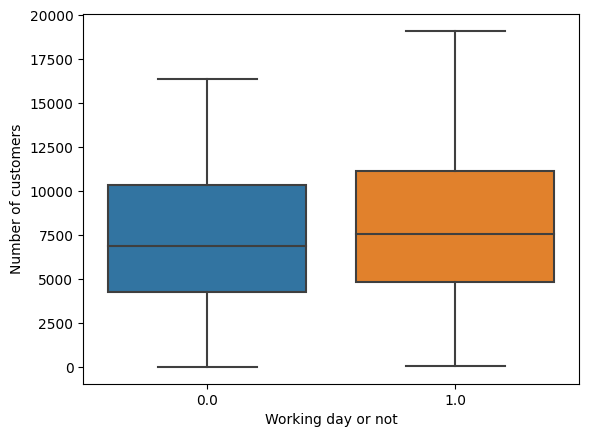

In [12]:
# plotting workday feature in boxplot against the count of customers
sb.boxplot(data = bike_df, x='working_day',y='total_cust')
plt.xlabel('Working day or not')
plt.ylabel('Number of customers')

In [13]:
# Correlation between working_day feature and the number of customers per day using the Kurskal Wallis H test
# for correlations between a continous and categorical variable
kruskal(bike_df['working_day'], bike_df['total_cust'])

KruskalResult(statistic=4596.399701396863, pvalue=0.0)

<AxesSubplot: xlabel='holiday', ylabel='total_cust'>

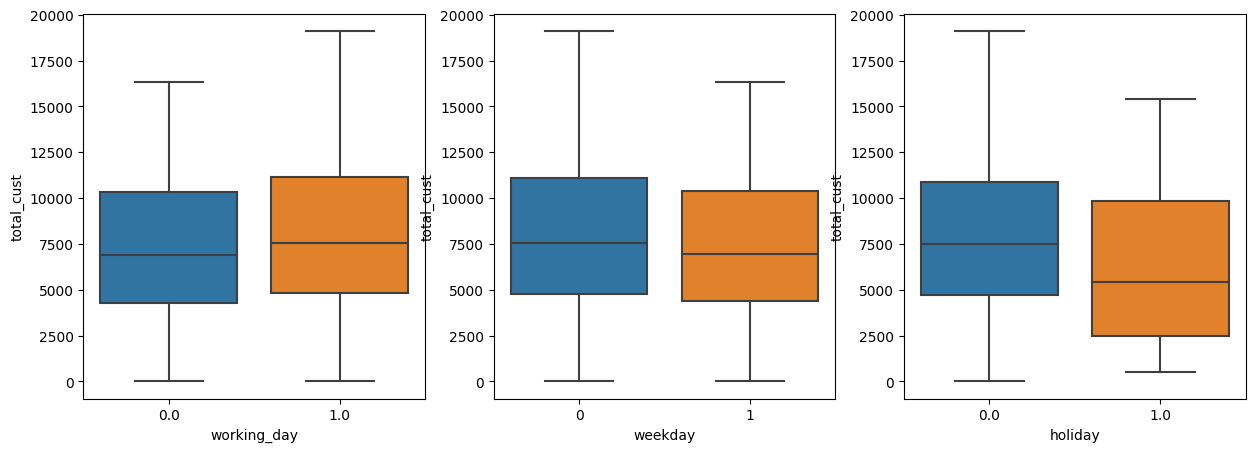

In [14]:
# Creating a new dataframe that encodes the weekday feature with 0 for monday through friday and 
# 1 for saturday and sunday
weekend_distinct_df= bike_df.copy()
weekend_distinct_df['weekday'] = weekend_distinct_df['weekday'].apply(lambda x: 1 if (x == 6 or x == 0) else 0)

#plot boxplots for comparison between the weekday and workingday feature
plt.figure(figsize=[15,5])
#boxplot for feature workingday
plt.subplot(1,3,1)
sb.boxplot(data=bike_df, x='working_day', y='total_cust')
#boxplot for feature weekday
plt.subplot(1,3,2)
sb.boxplot(data=weekend_distinct_df, x='weekday',y='total_cust')
#boxplot for feature holiday
plt.subplot(1,3,3)
sb.boxplot(data=bike_df, x='holiday',y='total_cust')

In [15]:
#means of each instance of workingday
bike_df.groupby('working_day')['total_cust'].mean()

working_day
0.0    7262.673563
1.0    7913.302144
Name: total_cust, dtype: float64

In [16]:
# means of each instance of weekday
weekend_distinct_df.groupby('weekday')['total_cust'].mean()

weekday
0    7878.716203
1    7322.511962
Name: total_cust, dtype: float64

In [17]:
# means of each instance of holiday
bike_df.groupby('holiday')['total_cust'].mean()

holiday
0.0    7771.698200
1.0    6060.685393
Name: total_cust, dtype: float64

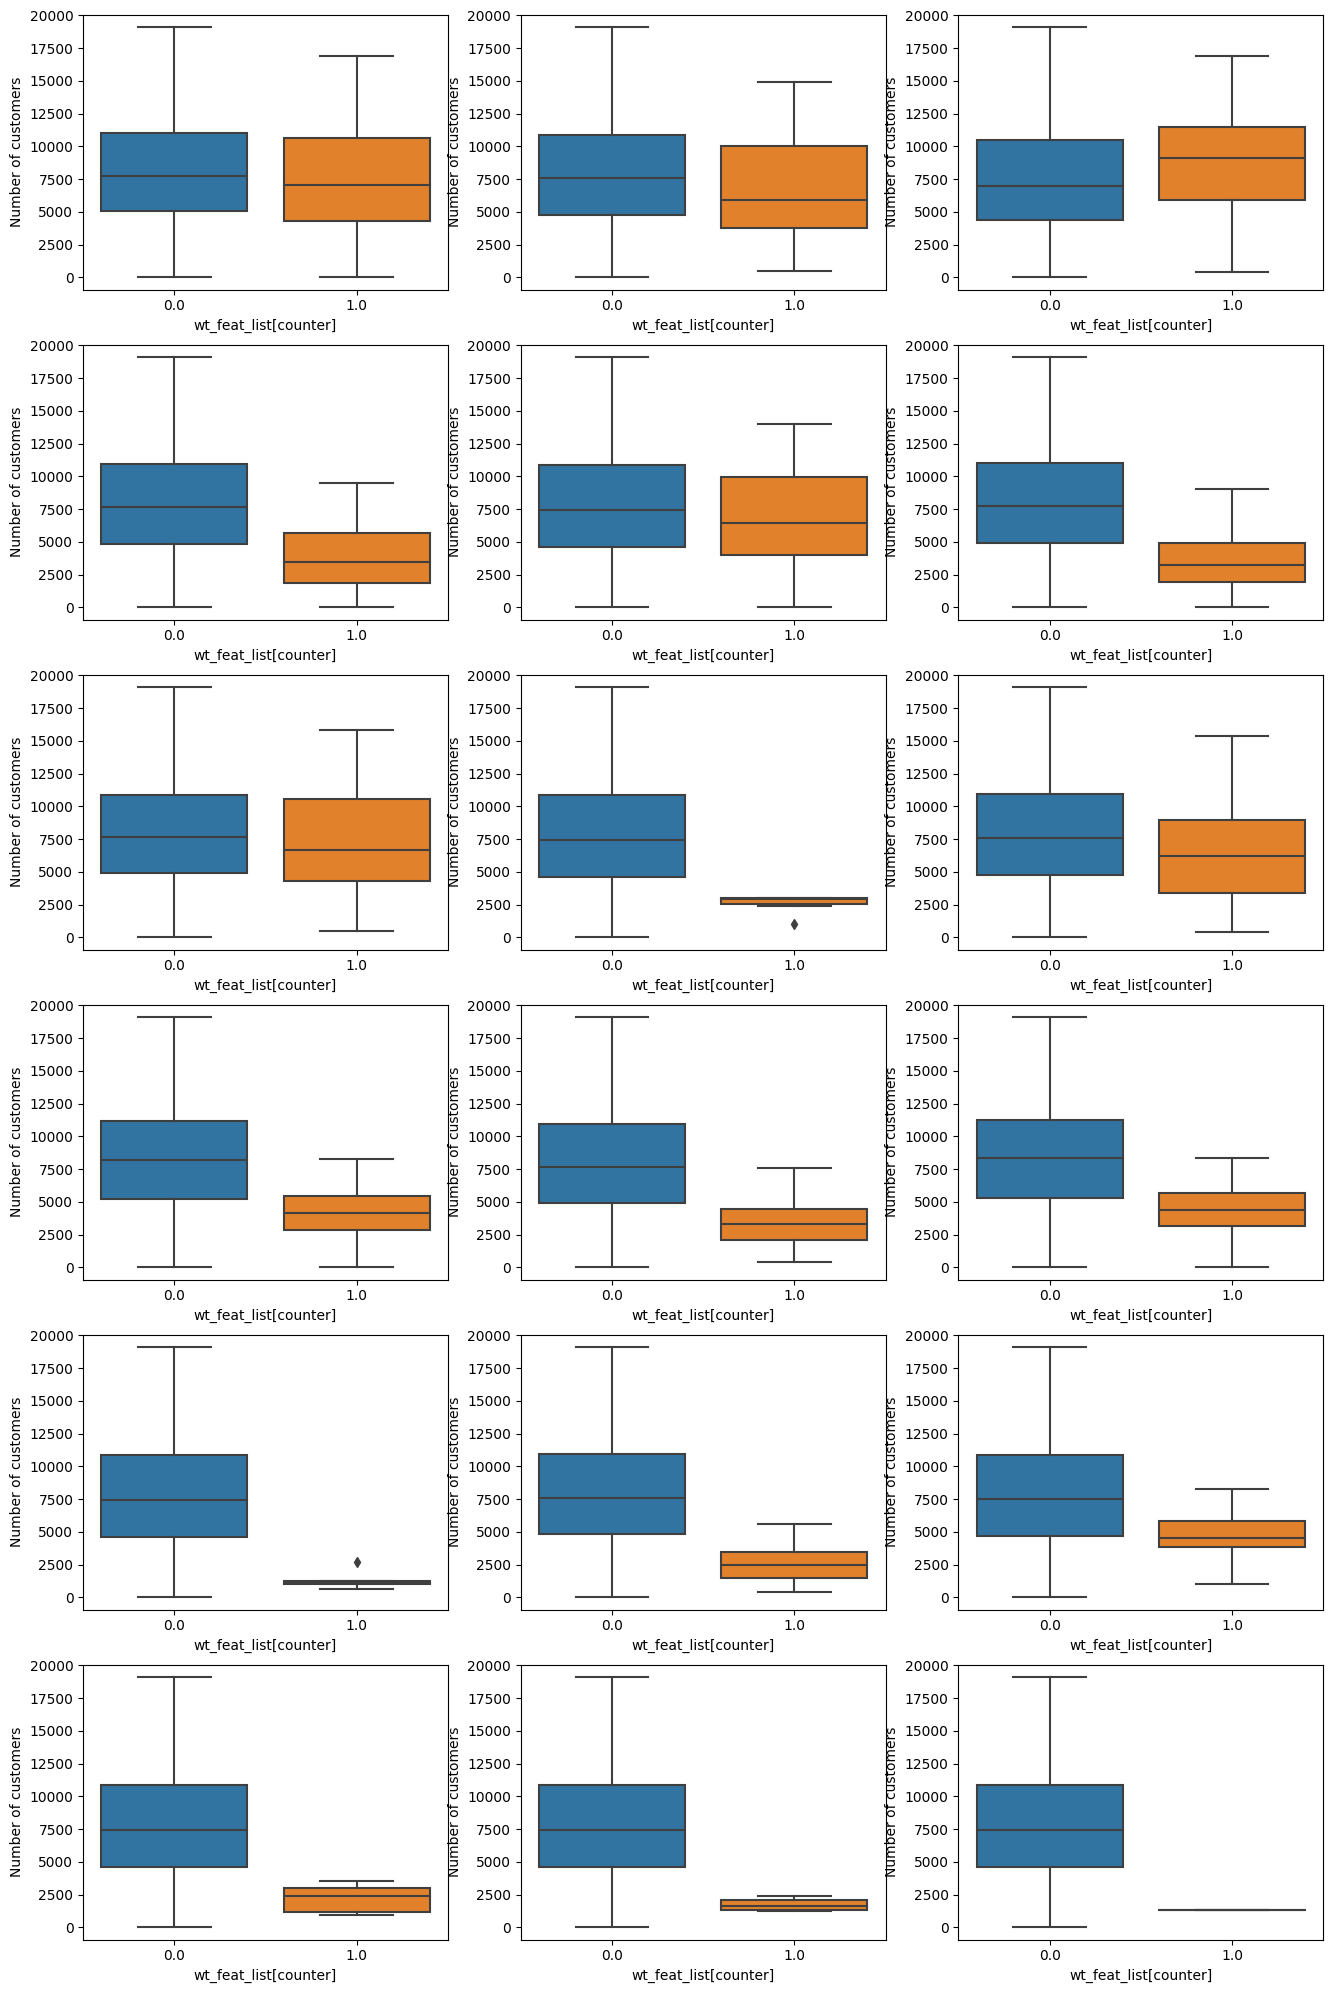

In [18]:
# plotting the revenue of the most common production companies vs. the rest
fig, ax = plt.subplots(6,3,figsize = [16,25])

#create list with all feature names
wt_feat_list = [x for x in bike_df.columns if 'wt_' in x]

#company counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 5 and i == 3:
            break
        else:
            ax[j][i] = sb.boxplot(data=bike_df, x = wt_feat_list[counter], y='total_cust',ax=ax[j][i])
            ax[j][i].set_ylabel('Number of customers')
            ax[j][i].set_xlabel('wt_feat_list[counter]')
            counter += 1

In [19]:
# consolidating similar weather types into new features(columns)
#fog, heavy fog, hail, haze, high wind
bike_df['foggy'] = bike_df['wt_fog'] + bike_df['wt_heavy_fog'] + bike_df['wt_hail'] + bike_df['wt_haze'] + bike_df['wt_high_wind']
bike_df['foggy'] = bike_df['foggy'].apply(lambda x : 0 if x == 0 else 1)

#thunder
bike_df['thunder'] = bike_df['wt_thunder']

# ice_fog, unknown, freeze_drizzle, freeze_rain, drift_snow
bike_df['ice'] = bike_df['wt_ice_fog'] + bike_df['wt_unknown'] + bike_df['wt_freeze_drizzle'] + bike_df['wt_freeze_rain'] + bike_df['wt_drift_snow']
bike_df['ice'] = bike_df['ice'].apply(lambda x: 0 if x == 0 else 1)

# sleet, glaze, snow
bike_df['sleet'] = bike_df['wt_sleet'] + bike_df['wt_glaze'] + bike_df['wt_snow']
bike_df['sleet'] = bike_df['sleet'].apply(lambda x: 0 if x == 0 else 1)

# mist, drizzle, rain, ground fog
bike_df['rain'] = bike_df['wt_mist'] + bike_df['wt_drizzle'] + bike_df['wt_rain'] + bike_df['wt_ground_fog']
bike_df['rain'] = bike_df['rain'].apply(lambda x: 0 if x == 0 else 1)

bike_df.drop(columns=wt_feat_list, inplace=True)


Text(0, 0.5, 'Number of customers')

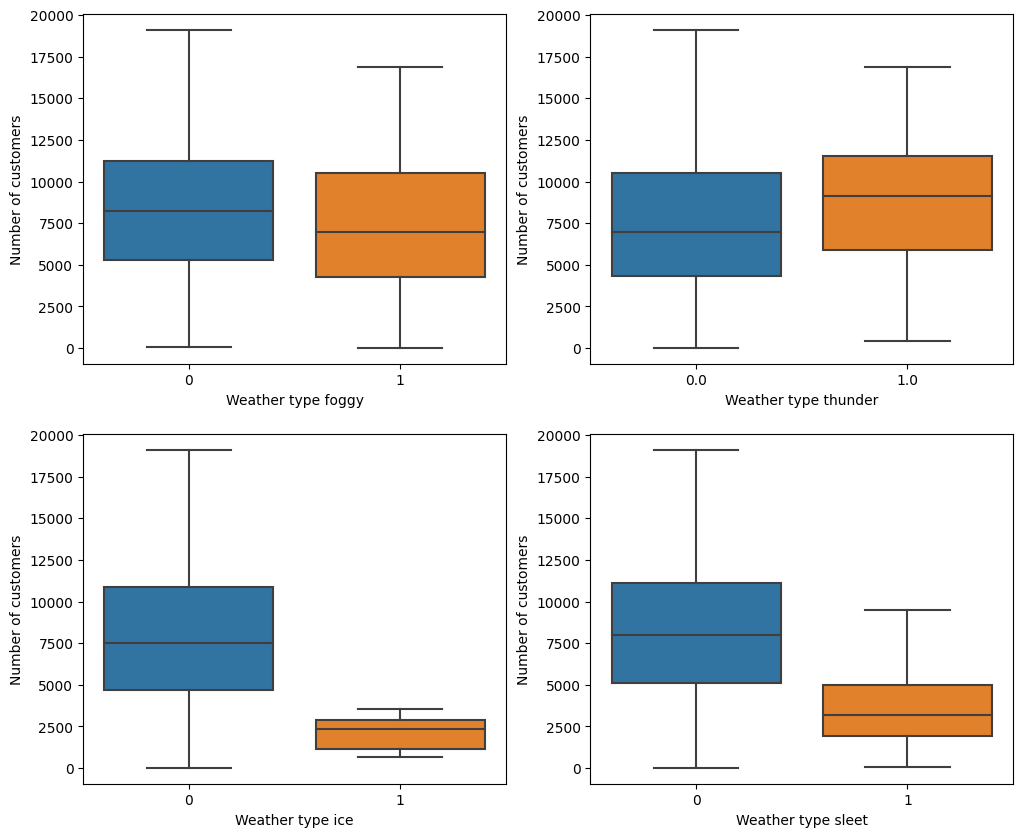

In [20]:
# boxplot comparison for condensed weather type features and target

plt.figure(figsize = [12, 10])

# boxplot for foggy feature
plt.subplot(2,2,1)
sb.boxplot(data = bike_df, x = 'foggy', y = 'total_cust')
plt.xlabel('Weather type foggy')
plt.ylabel('Number of customers')

# boxplot for thunder feature
plt.subplot(2,2,2)
sb.boxplot(data = bike_df, x = 'thunder', y = 'total_cust')
plt.xlabel('Weather type thunder')
plt.ylabel('Number of customers')

# boxplot for ice feature
plt.subplot(2,2,3)
sb.boxplot(data = bike_df, x = 'ice', y = 'total_cust')
plt.xlabel('Weather type ice')
plt.ylabel('Number of customers')

# boxplt for sleet feature
plt.subplot(2,2,4)
sb.boxplot(data = bike_df, x = 'sleet', y = 'total_cust')
plt.xlabel('Weather type sleet')
plt.ylabel('Number of customers')

<Figure size 1500x600 with 0 Axes>

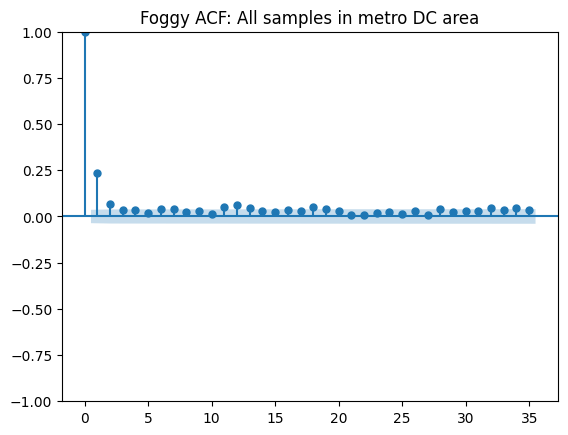

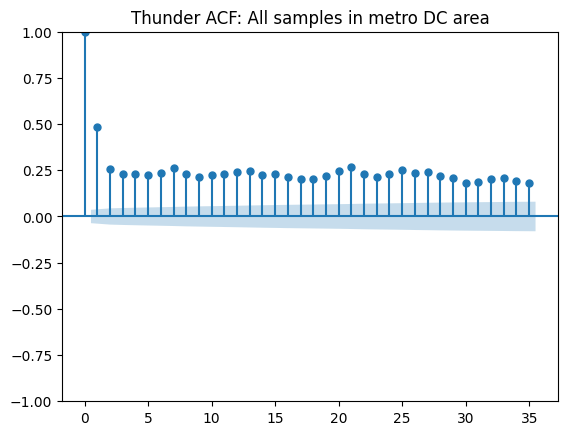

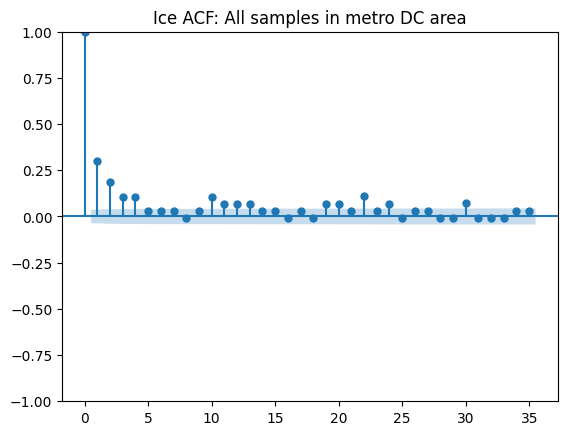

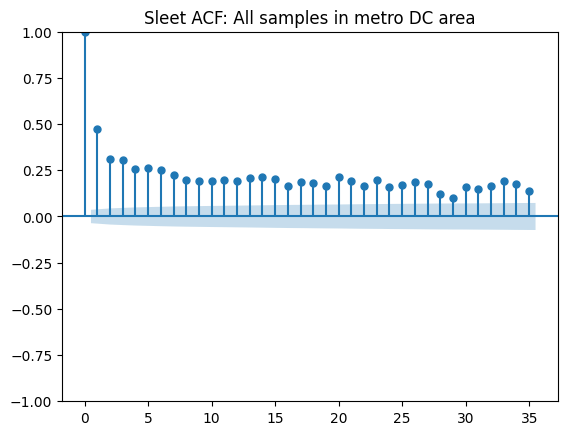

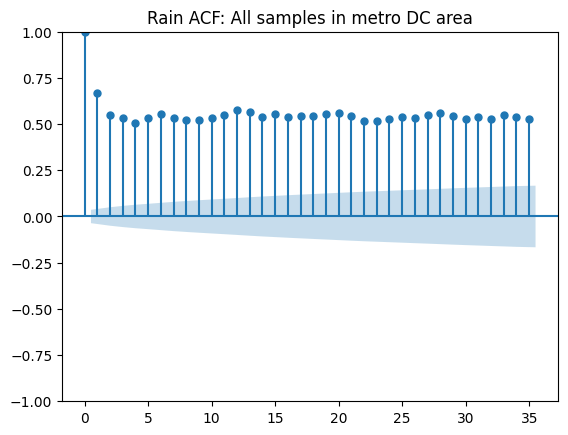

In [21]:
# plotting the autocorrelation function of condensed wt_features
plt.figure(figsize=[15,6])

plot_acf(bike_df['foggy'], title='Foggy ACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['thunder'], title='Thunder ACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['ice'], title='Ice ACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['sleet'], title='Sleet ACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['rain'], title='Rain ACF: All samples in metro DC area',)
plt.show()

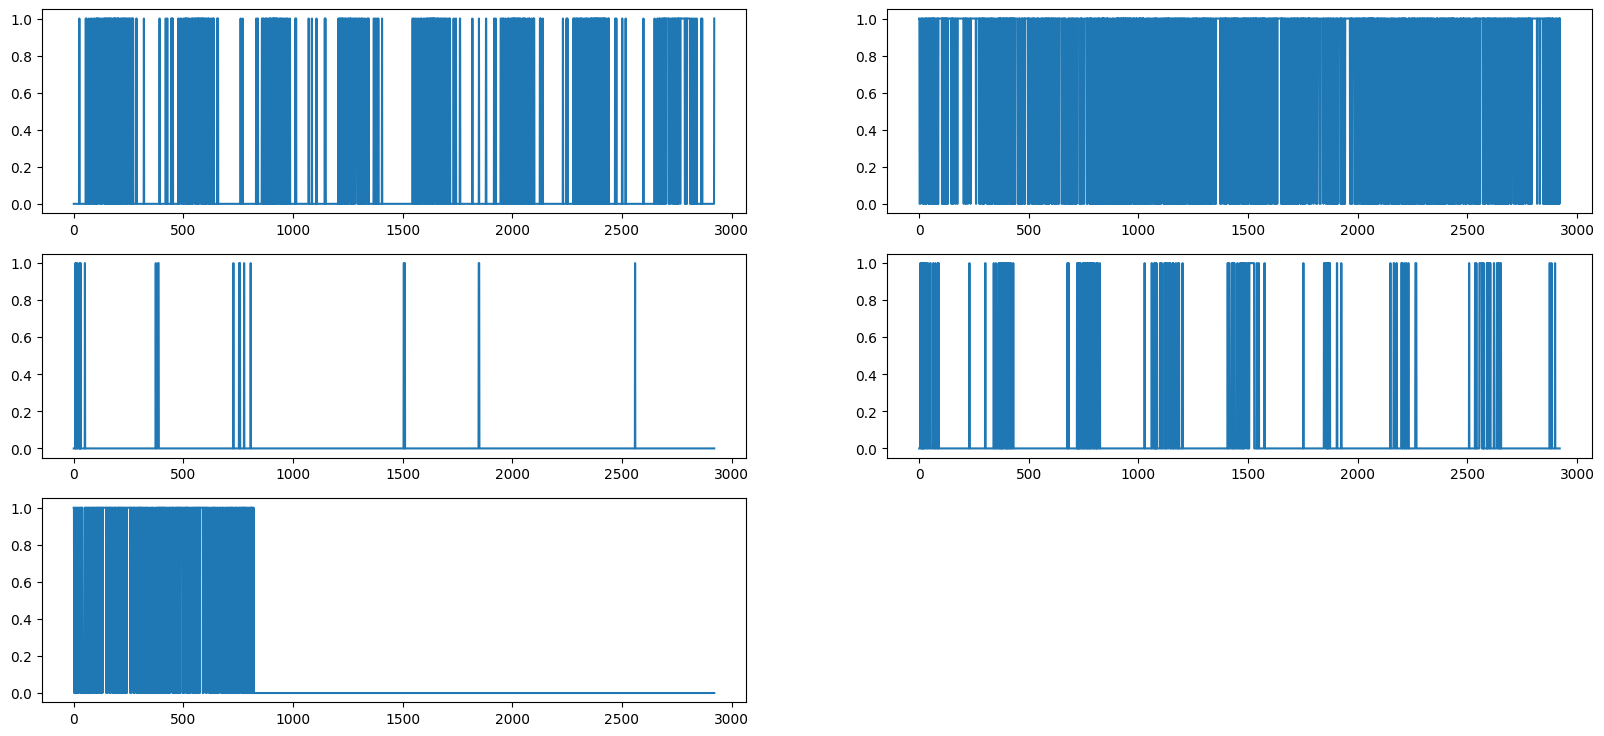

In [22]:


# plotting condensed weather features
plt.figure(figsize=[20,9])

plt.subplot(3,2,1)
plt.plot(bike_df['thunder'])

plt.subplot(3, 2, 2)
plt.plot(bike_df['foggy'])

plt.subplot(3, 2, 3)
plt.plot(bike_df['ice'])

plt.subplot(3, 2, 4)
plt.plot(bike_df['sleet'])

plt.subplot(3, 2, 5)
plt.plot(bike_df['rain'])

In [23]:
# rain feature data collection discontinued after 2 years
bike_df.drop(columns=['rain'], inplace=True)

# list for all rolling sums between weather feature and target
def best_window_sum(x, y, max_window):
    corr_temp_cust = []
    for i in range(1, max_window):
        roll_val = list(x.rolling(i).sum()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    # get the optimal window size for rolling mean
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results

In [24]:
# optimal window for rolling sum for foggy
print(best_window_sum(bike_df['foggy'], bike_df['total_cust'], 30))

# correlation for window size determined by foggy
foggy_mean = bike_df['foggy'].rolling(8).sum()[7:-1]
pearsonr(foggy_mean, bike_df['total_cust'][8:])

{3: -0.03454117565250649, 29: -0.08701177677103925}


PearsonRResult(statistic=-0.056992243357476005, pvalue=0.0020859976421017255)

In [25]:
# optimal window for rolling sum for thunder
print(best_window_sum(bike_df['thunder'], bike_df['total_cust'], 30))

# correlation for window size determined by thunder
thunder_mean = bike_df['thunder'].rolling(8).sum()[7:-1]
pearsonr(thunder_mean, bike_df['total_cust'][8:])

{29: 0.4348951971254514, 1: 0.21740383154927378}


PearsonRResult(statistic=0.3589870088310652, pvalue=2.3622036013534496e-89)

In [26]:
#optimal window for rolling sum for sleet
print(best_window_sum(bike_df['sleet'], bike_df['total_cust'], 30))

# correlationn for window size determined by sleet
sleet_mean = bike_df['sleet'].rolling(8).sum()[7:-1]
pearsonr(sleet_mean, bike_df['total_cust'][8:])


{1: -0.30643580747310273, 21: -0.43628302776959116}


PearsonRResult(statistic=-0.4032156282343481, pvalue=2.32726408555059e-114)

Text(158.08159722222223, 0.5, 'Columns')

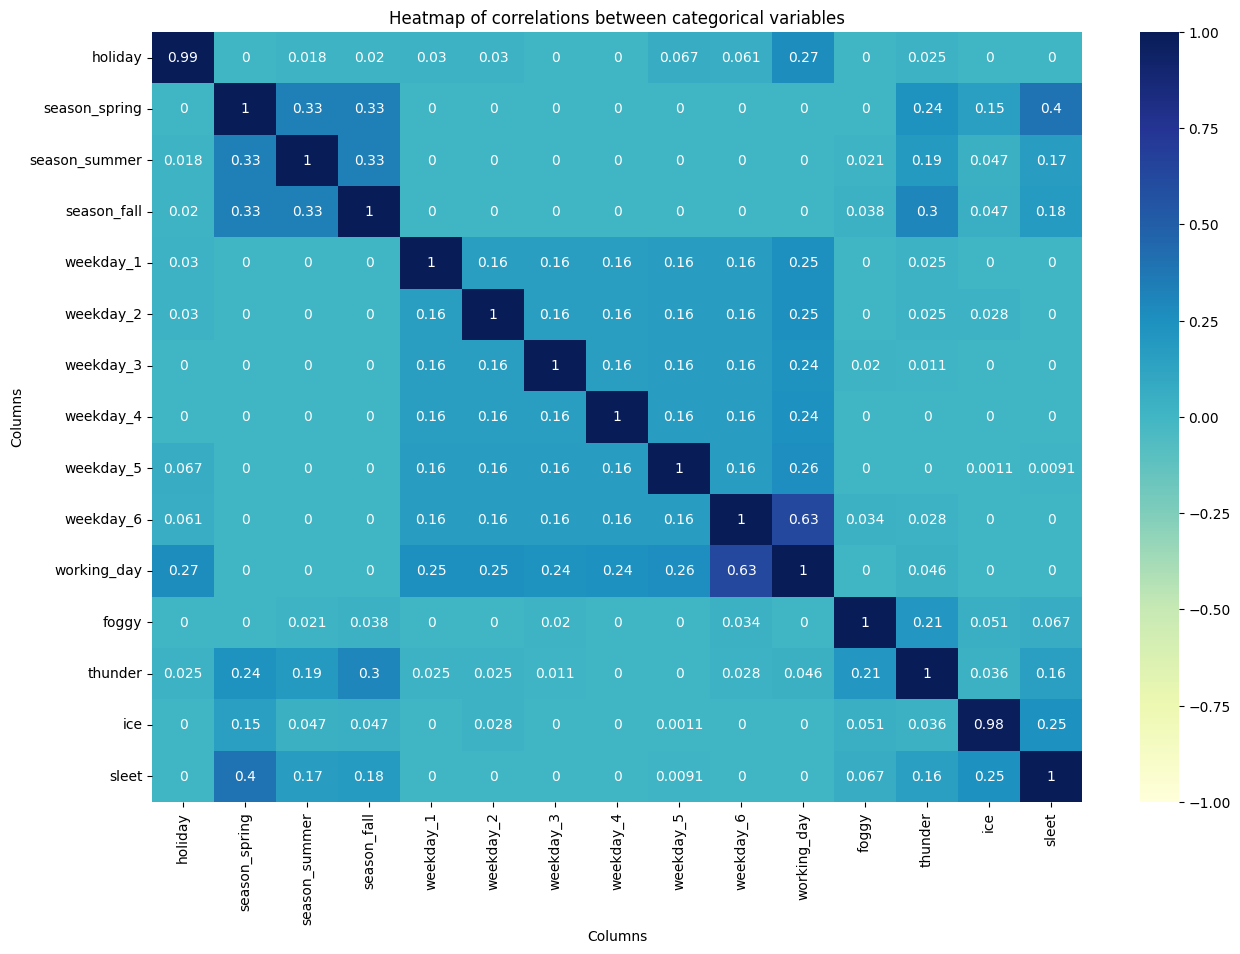

In [27]:
# drop any non-categorical variables
bike_df_corr_cat= bike_df.drop(columns=['date_datetime', 'weekday', 'temp_min', 'temp_max', 'temp_observ', 'precip', 'wind', 'total_cust'], axis = 1)

# from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x,y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

# correlation matrix with cramer's V coefficients
corr_matrix = pd.DataFrame(data = None, index=np.arange(len(bike_df_corr_cat.columns)), columns = bike_df_corr_cat.columns)
for col in bike_df_corr_cat.columns:
    count = 0
    for val in bike_df_corr_cat.columns:
        corr_cat = cramers_v(bike_df_corr_cat[col], bike_df_corr_cat[val])
        corr_matrix[col][count] = corr_cat
        count += 1
    corr_matrix = corr_matrix.astype('float')

#add index to the dataframe
corr_matrix['columns']= bike_df_corr_cat.columns
corr_matrix.set_index('columns', inplace=True)

#plot a heatmap for correlations beween categorical variables
plt.figure(figsize=[15,10])
sb.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, center=0,fmt='.2g', cmap='YlGnBu')
plt.title('Heatmap of correlations between categorical variables')
plt.xlabel('Columns')
plt.ylabel('Columns')



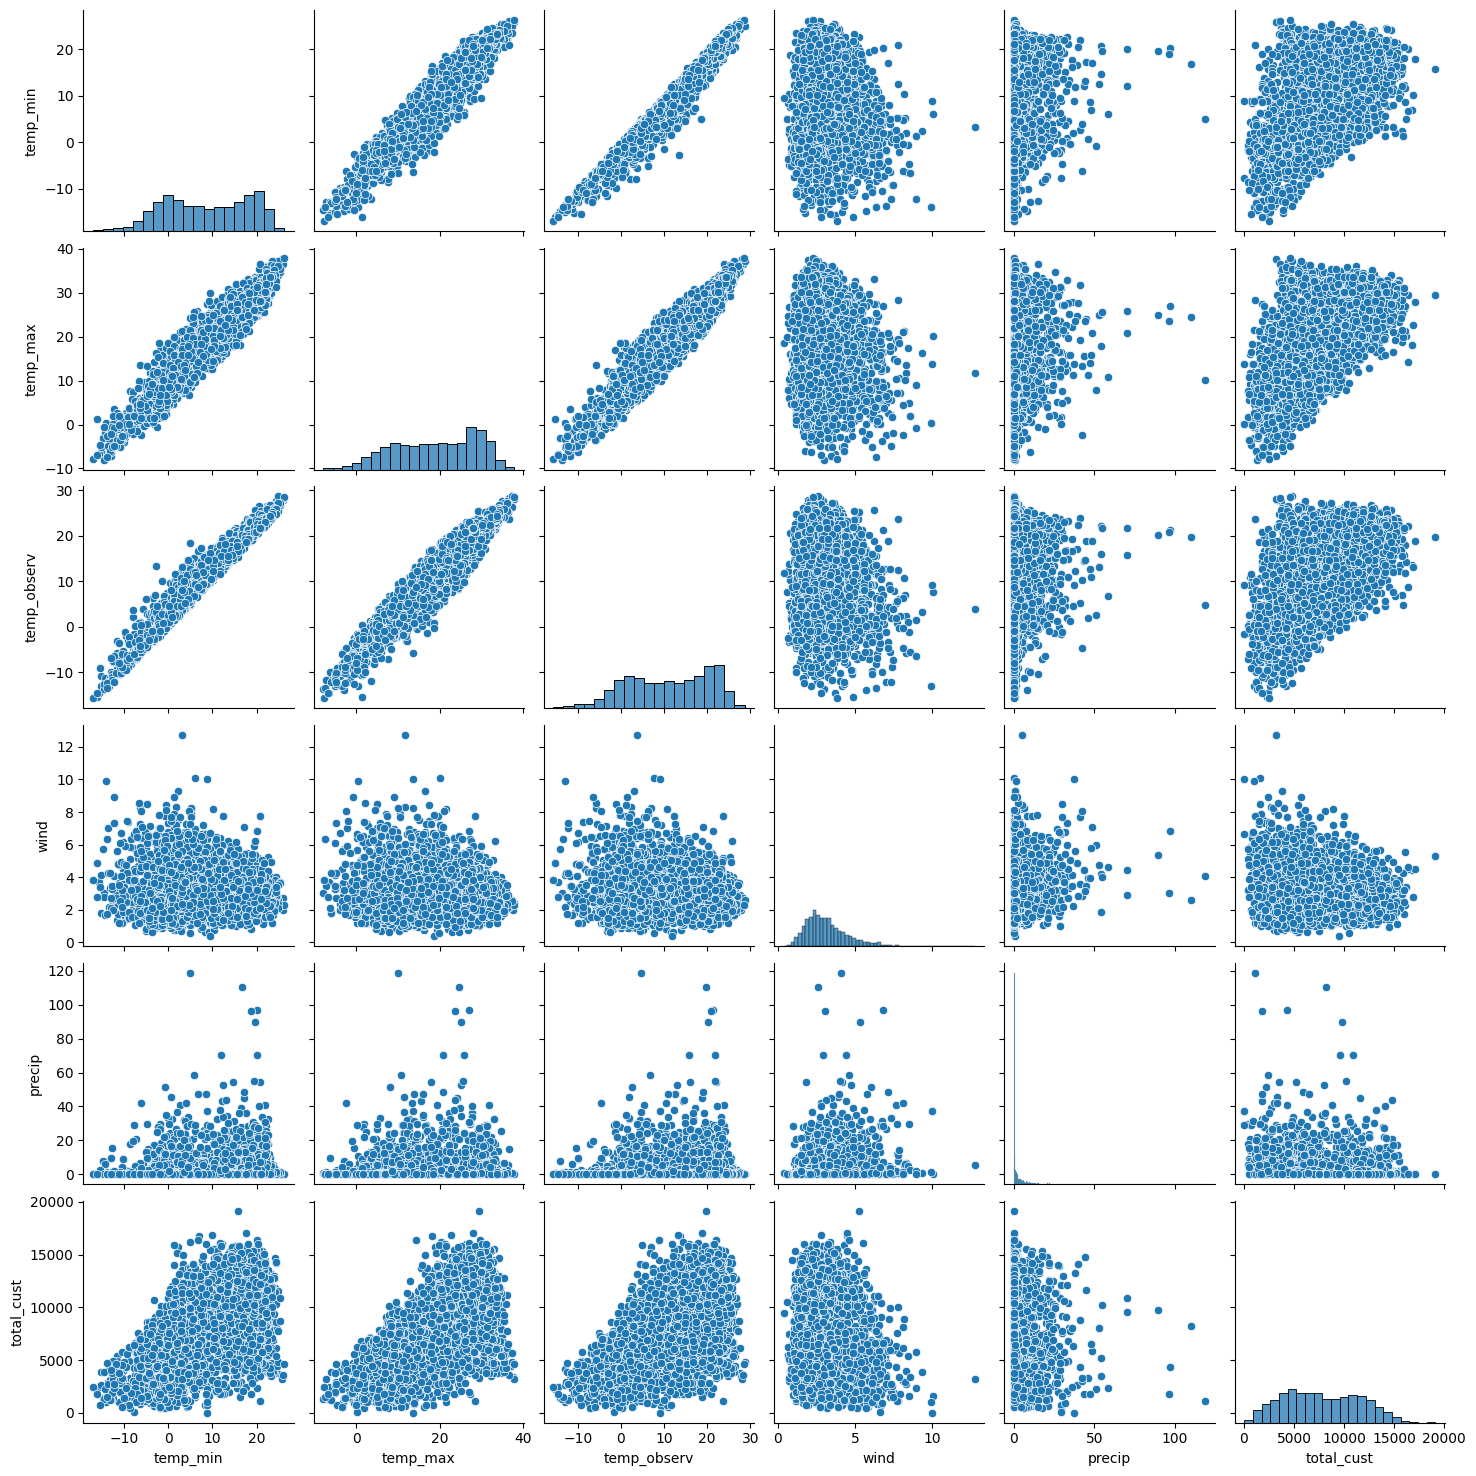

In [28]:
# distribution and scatterplot between each continuos varable pair
sb.pairplot(bike_df, vars=['temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust'])

Text(95.58159722222221, 0.5, 'Columns')

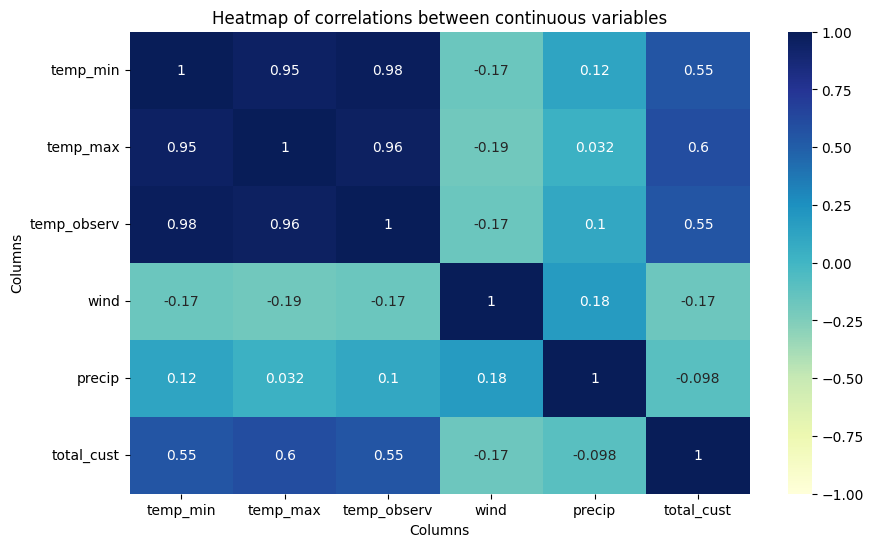

In [29]:
# correlation matrix
bike_df_corr = bike_df[['temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust']].corr()

# create a heatmap to visualize the results
plt.figure(figsize=[10,6])
sb.heatmap(bike_df_corr, annot=True, vmin=-1, vmax=1, center=0, cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables')
plt.xlabel('Columns')
plt.ylabel('Columns')

In [30]:
# get list for all correlations betwen a feature and total_cust with different rolling means
def best_window(x,y, max_window):
    corr_temp_cust = []
    for i in range(1, max_window):
        roll_val = list(x.rolling(i).mean()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    
    # get the optimal window size for rolling mean between a feature and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val + 1: opt_corr_max, min_val + 1: opt_corr_min}
    return results

# get list for all correlations between a feature and total_cust with different rolling std_dev
def best_window_std(x, y, max_window):
    corr_temp_cust = []
    for i in range(2, max_window):
        roll_val = list(x.rolling(i).std()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    
    # get the optimal window size for rolling std dev between a feature and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]

    results = {max_val + 1: opt_corr_max, min_val + 1: opt_corr_min}
    return results


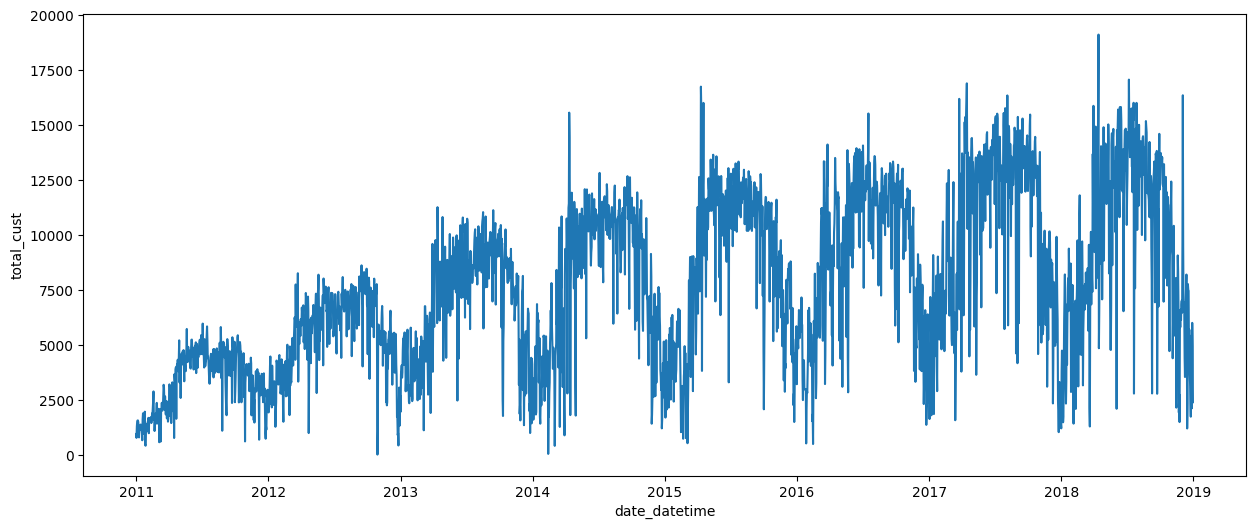

In [31]:
# plot the overall total_cust values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='total_cust', data=bike_df)

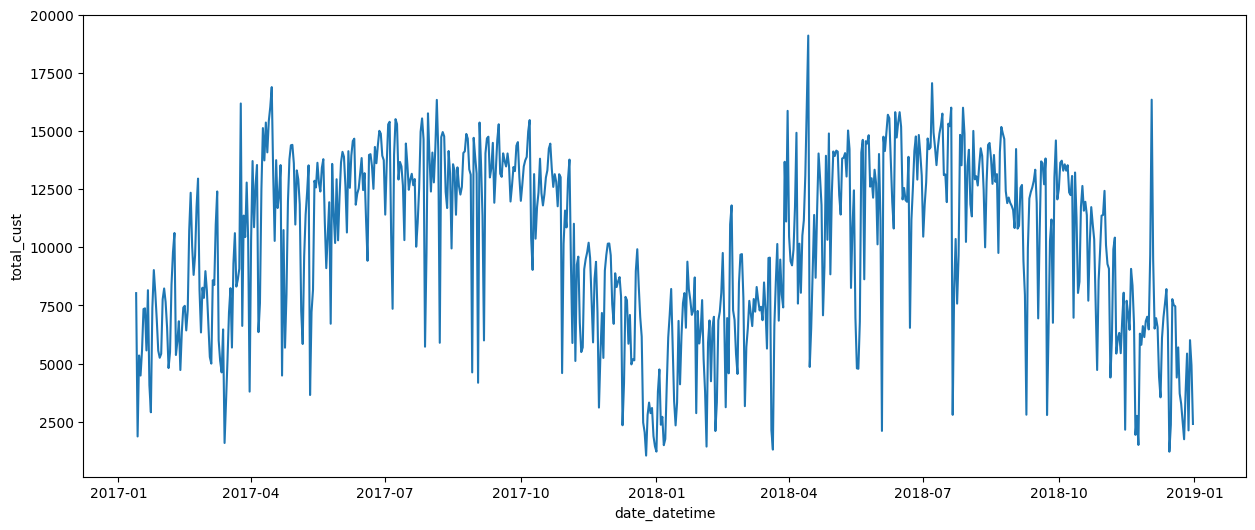

In [32]:
# plotting the last two years of timeseries data
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='total_cust',data=bike_df[-718:])

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

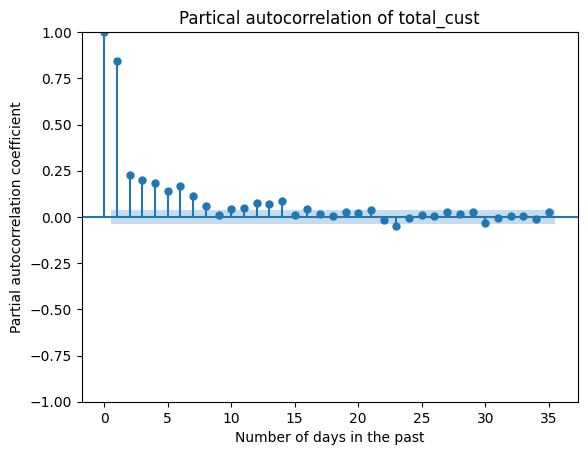

In [33]:
# plotting the partial autocorrelation for total_cust
plot_pacf(bike_df['total_cust'], title='Partical autocorrelation of total_cust',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show


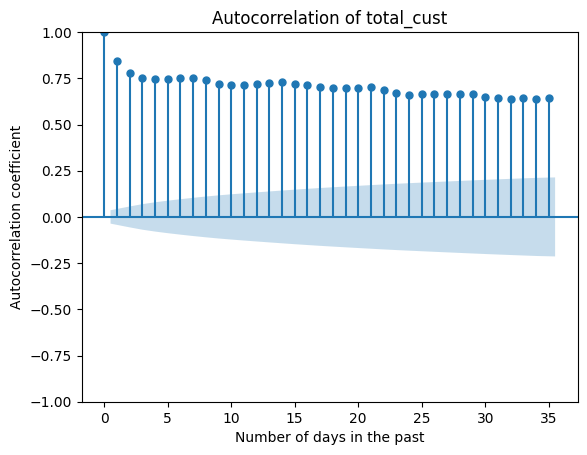

In [34]:
# plotting the autocorrelation for total_cust
plot_acf(bike_df['total_cust'], title='Autocorrelation of total_cust',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation coefficient')
plt.show()

In [35]:
# optimal window for rolling std of total_cust
print(best_window_std(bike_df['total_cust'], bike_df['total_cust'], 30))

# correlation for window size determined by total_cust
cust_mean = bike_df['total_cust'].rolling(8).std()[7:-1]
pearsonr(cust_mean, bike_df['total_cust'][8:])

{28: 0.4229738021169006, 1: 0.14849910136165323}


PearsonRResult(statistic=0.3208335205188535, pvalue=9.428776427881618e-71)

In [36]:
# get the optimal number for rolling mean for total_cust
print(best_window(bike_df['total_cust'], bike_df['total_cust'], 30))

# get the correlation for window size determined by total_cust
cust_mean = bike_df['total_cust'].rolling(8).mean()[7:-1]
pearsonr(cust_mean, bike_df['total_cust'][8:])

{8: 0.8523138629506778, 29: 0.8292172214075906}


PearsonRResult(statistic=0.8523138629506778, pvalue=0.0)

In [37]:
# add the value t-1 to dataframe
bike_df['total_cust_t-1'] = bike_df['total_cust'].shift()

/tmp/ipykernel_6094/2495531093.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_seasons = temp_spring.append(temp_summer).append(temp_fall)
/tmp/ipykernel_6094/2495531093.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_seasons = temp_spring.append(temp_summer).append(temp_fall)


<AxesSubplot: >

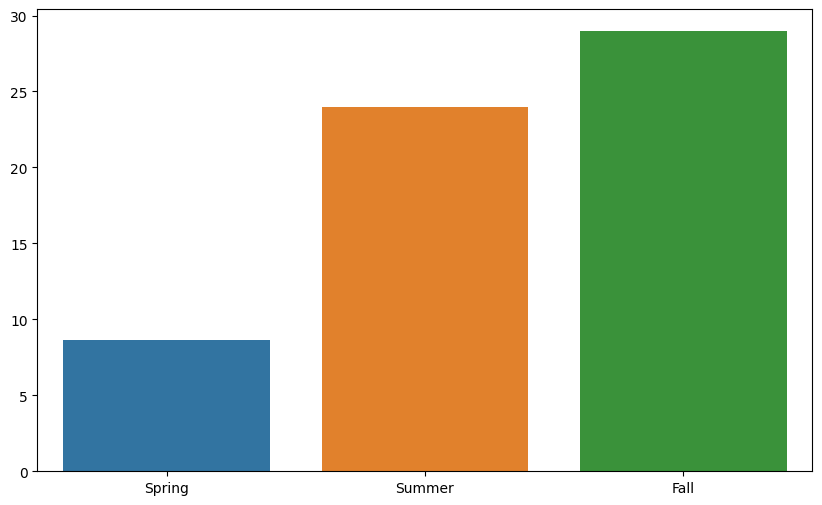

In [38]:
# create series that group the mean temperature per season
temp_spring = bike_df.groupby('season_spring')['temp_max'].mean().rename({1: 'Spring'})
temp_summer = bike_df.groupby('season_summer')['temp_max'].mean().rename({1:'Summer'})
temp_fall = bike_df.groupby('season_fall')['temp_max'].mean().rename({1:'Fall'})

# add them to one series and drop the rows with index 0
temp_seasons = temp_spring.append(temp_summer).append(temp_fall)
temp_seasons.drop(labels=[0], inplace=True)

#plot average temp_max per season
plt.figure(figsize=[10,6])
sb.barplot(x=temp_seasons.index, y=temp_seasons.values)

In [39]:
# create series that groups average users per season
cust_spring= bike_df.groupby('season_spring')['total_cust'].mean().rename({1:'Spring'})
cust_summer= bike_df.groupby('season_summer')['total_cust'].mean().rename({1:'Summer'})
cust_fall = bike_df.groupby('season_fall')['total_cust'].mean().rename({1:'Fall'})

# add them to on series and drop the rows with index 0
cust_seasons = cust_spring.append(cust_summer).append(cust_fall)
cust_seasons.drop(labels=[0], inplace=True)

/tmp/ipykernel_6094/3926754679.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cust_seasons = cust_spring.append(cust_summer).append(cust_fall)
/tmp/ipykernel_6094/3926754679.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cust_seasons = cust_spring.append(cust_summer).append(cust_fall)


<Figure size 1500x700 with 0 Axes>

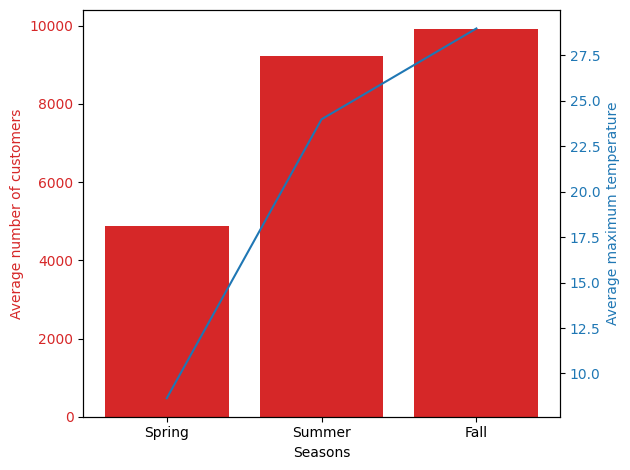

In [40]:
# assign x, y1 and y2
x = list(temp_seasons.index)
y1 = cust_seasons.values
y2 = temp_seasons.values

#from https://matplotlib.org/gallery/api/two_scales.html
# create3 plot containing both average counts of customers and average temp per month
plt.figure(figsize=[15,7])
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()   # instantiantes a second axes that share the same x-axis

color1 = 'tab:red'
ax1.set_xlabel('Seasons')
ax1.set_ylabel('Average number of customers', color=color1)
ax1.bar(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2 = 'tab:blue'
ax2.set_ylabel('Average maximum temperature', color=color2)
ax2.plot(x, y2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Maximum temperature vs. number of customers')

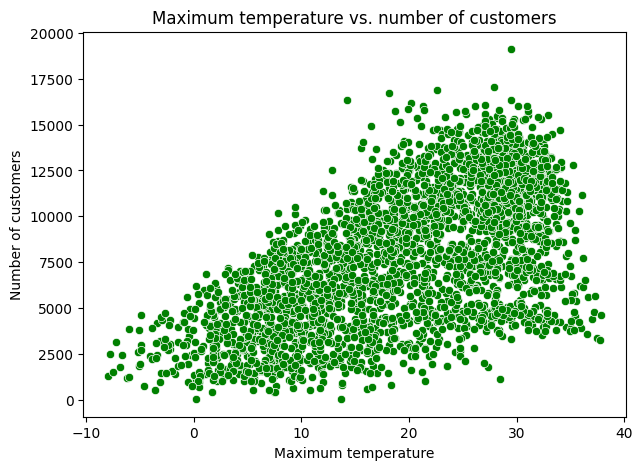

In [41]:
# plotting temp feature agains the target label total_cust
plt.figure(figsize=[7,5])
sb.scatterplot(data = bike_df, x='temp_max', y='total_cust', color='green')
plt.xlabel('Maximum temperature')
plt.ylabel('Number of customers')
plt.title('Maximum temperature vs. number of customers')

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


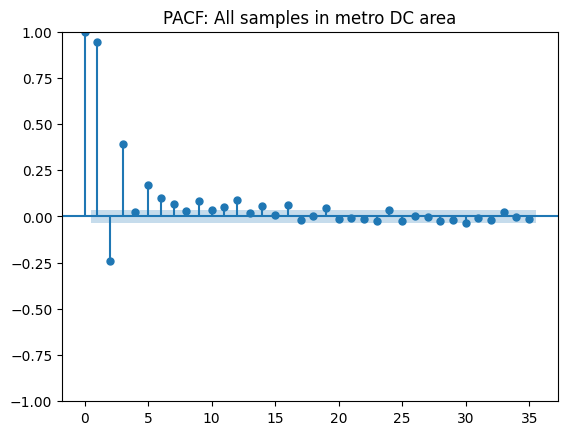

In [42]:
# partial autocorrelation of temp_max
plot_pacf(bike_df['temp_max'], title='PACF: All samples in metro DC area',)
plt.show()

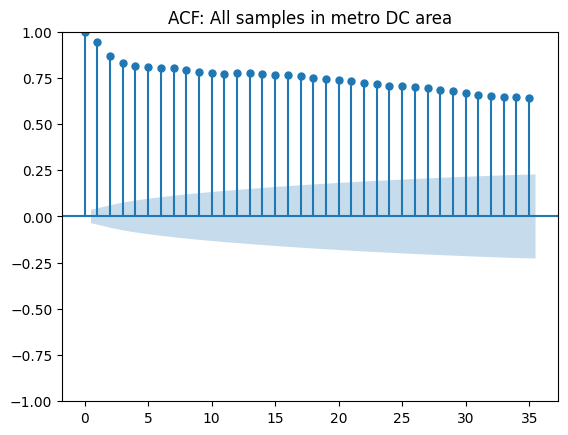

In [43]:
# autocorreleation of temp_max
plot_acf(bike_df['temp_max'], title='ACF: All samples in metro DC area',)
plt.show()

In [44]:
# optimal window for rolling std for temp_max
print(best_window_std(bike_df['temp_max'], bike_df['total_cust'], 30))

# correlation for window size determined by temp_max
temp_mean = bike_df['temp_max'].rolling(8).std()[7:-1]
pearsonr(temp_mean, bike_df['total_cust'][8:])

{1: -0.14741062385066672, 21: -0.27608100636622823}


PearsonRResult(statistic=-0.22323589445416725, pvalue=3.119764870939802e-34)

In [45]:
# optimal window for rolling mean for temperature
best_window(bike_df['temp_max'], bike_df['total_cust'], 30)

{16: 0.558195538335907, 29: 0.540475143240248}

Text(0.5, 0, 'Time')

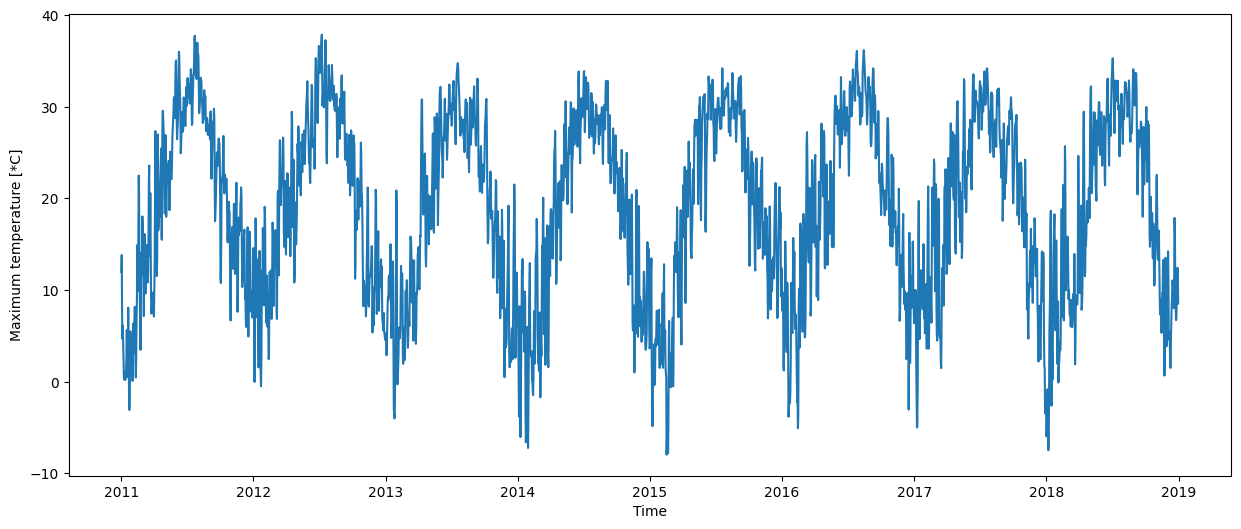

In [46]:
# plot the overall temp_max values for entire timeseries
plt.figure(figsize=[15,6])
ax= sb.lineplot(x='date_datetime', y='temp_max', data=bike_df)
plt.ylabel('Maximum temperature [*C]')
plt.xlabel('Time')

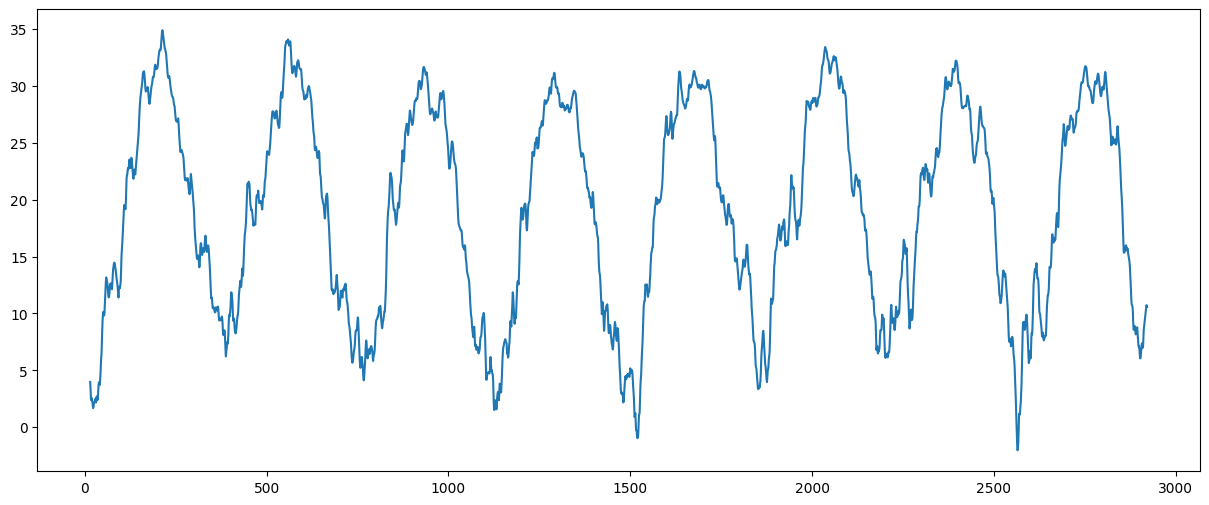

In [47]:
# plot of rolling means -- max temperatures
plt.figure(figsize=[15,6])
plt.plot(bike_df['temp_max'].rolling(16).mean())

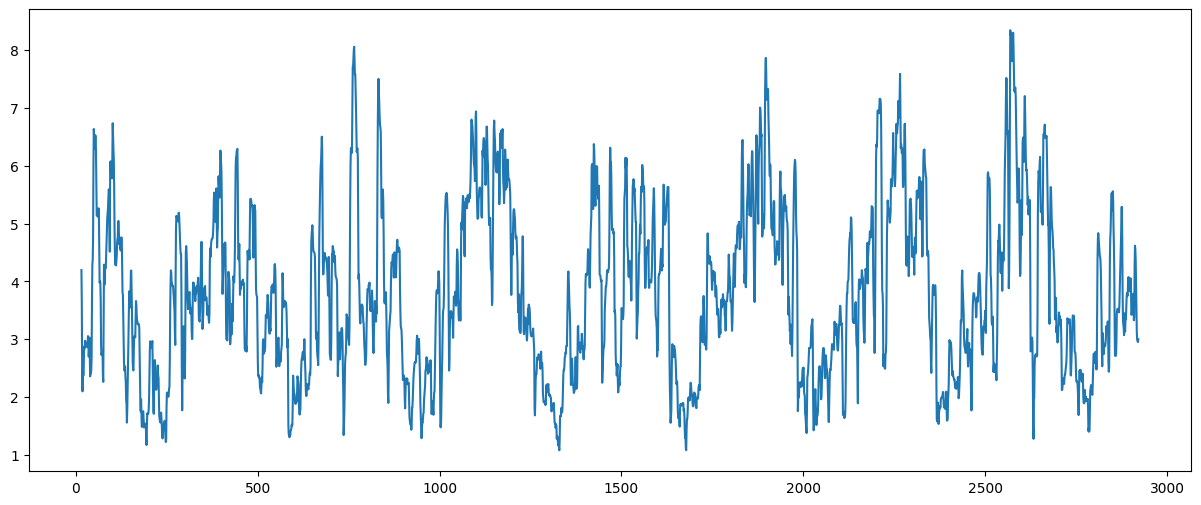

In [48]:
# plot of rolling stds -- max temperatures
plt.figure(figsize=[15,6])
plt.plot(bike_df['temp_max'].rolling(16).std())

Text(0.5, 1.0, 'Minimum temperature vs. number of customers')

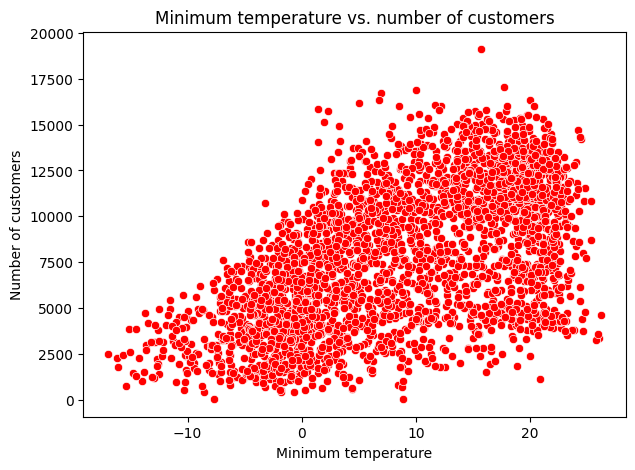

In [49]:
# plotting temp_min feature against the target label
plt.figure(figsize=[7,5])
sb.scatterplot(data=bike_df, x='temp_min', y='total_cust', color='red')
plt.xlabel('Minimum temperature')
plt.ylabel('Number of customers')
plt.title('Minimum temperature vs. number of customers')

In [50]:
# engineer new categorical temp features
bike_df_cat = bike_df.copy()
bike_df_cat['very_cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 0 else 0)
bike_df_cat['cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 10 and x >=0 else 0)
bike_df_cat['cool'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 20 and x >= 10 else 0)
bike_df_cat['warm'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 30 and x >= 20 else 0)
bike_df_cat['hot'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x >= 30 else 0)

bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']] = bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']].shift()
bike_df_cat = bike_df_cat.iloc[1:,:]

pearsonr(bike_df_cat['total_cust'], bike_df_cat['cold'])

PearsonRResult(statistic=-0.4015910826314985, pvalue=1.222420256024716e-113)

Text(0, 0.5, 'Number of customers')

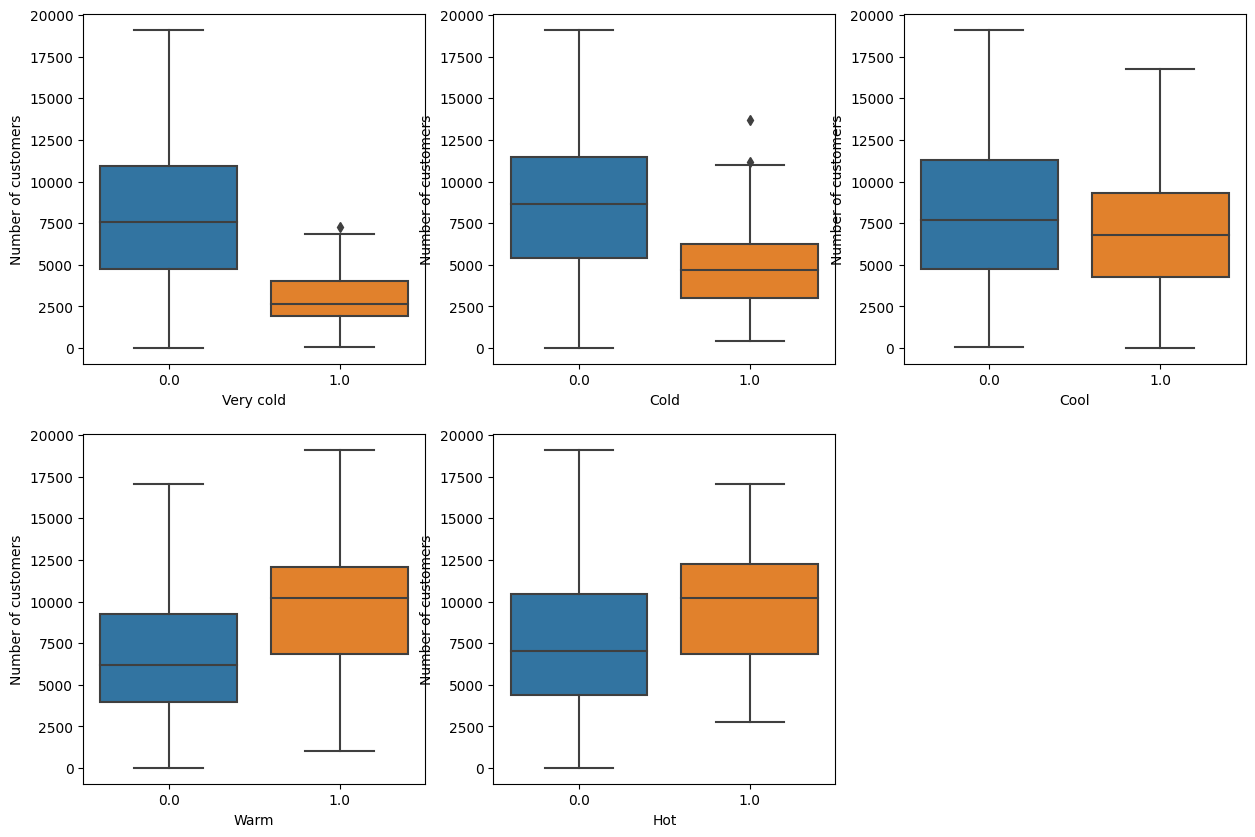

In [51]:
#plot categorized temperature
plt.figure(figsize=[15,10])
plt.subplot(2,3,1)
sb.boxplot(x = bike_df_cat['very_cold'], y = bike_df_cat['total_cust'])
plt.xlabel('Very cold')
plt.ylabel('Number of customers')

plt.subplot(2,3,2)
sb.boxplot(x = bike_df_cat['cold'], y = bike_df_cat['total_cust'])
plt.xlabel('Cold')
plt.ylabel('Number of customers')

plt.subplot(2,3,3)
sb.boxplot(x = bike_df_cat['cool'], y = bike_df_cat['total_cust'])
plt.xlabel('Cool')
plt.ylabel('Number of customers')

plt.subplot(2,3,4)
sb.boxplot(x = bike_df_cat['warm'], y = bike_df_cat['total_cust'])
plt.xlabel('Warm')
plt.ylabel('Number of customers')

plt.subplot(2,3,5)
sb.boxplot(x = bike_df_cat['hot'], y = bike_df_cat['total_cust'])
plt.xlabel('Hot')
plt.ylabel('Number of customers')

Text(0.5, 1.0, 'Precipitation vs. number of customers')

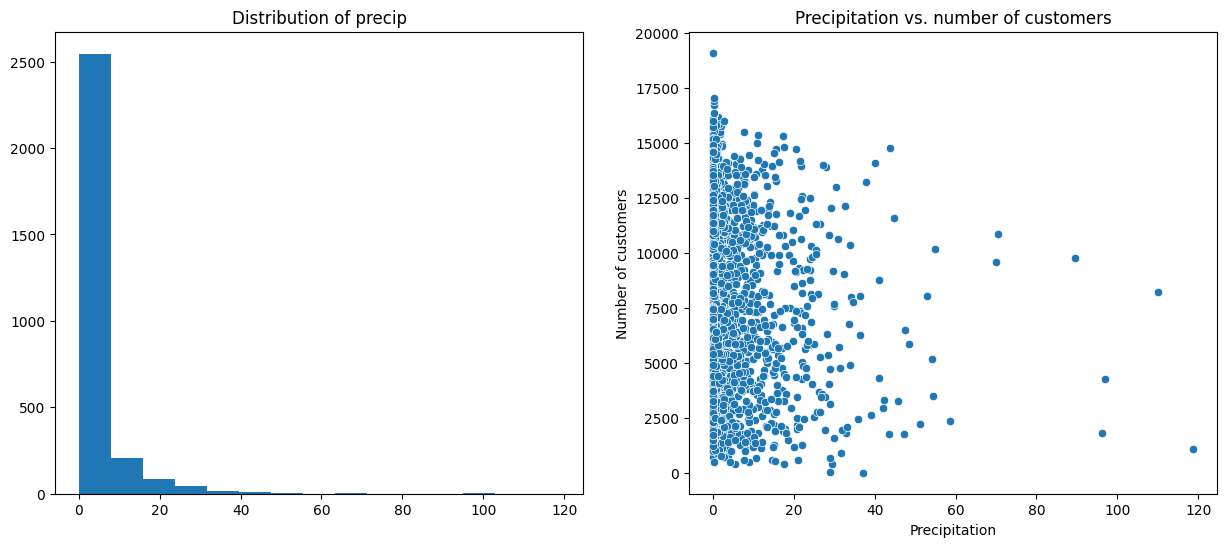

In [52]:
# plotting the distribution of precip
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.hist(bike_df['precip'], bins = 15)
plt.title('Distribution of precip')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x = 'precip', y = 'total_cust')
plt.xlabel('Precipitation')
plt.ylabel('Number of customers')
plt.title('Precipitation vs. number of customers')

Text(0.5, 1.0, 'Distribution of precip')

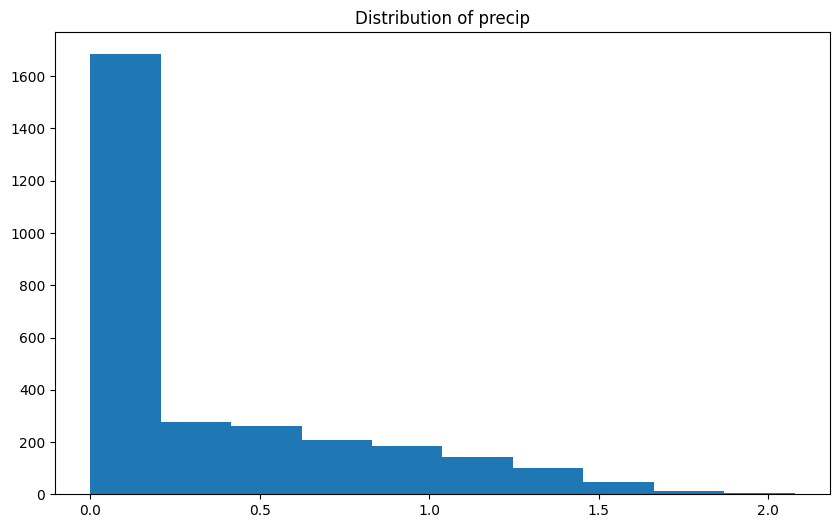

In [53]:
# distribution of precip
plt.figure(figsize=[10,6])
x=np.log10(bike_df['precip'] + 1)
plt.hist(x)
plt.title('Distribution of precip')

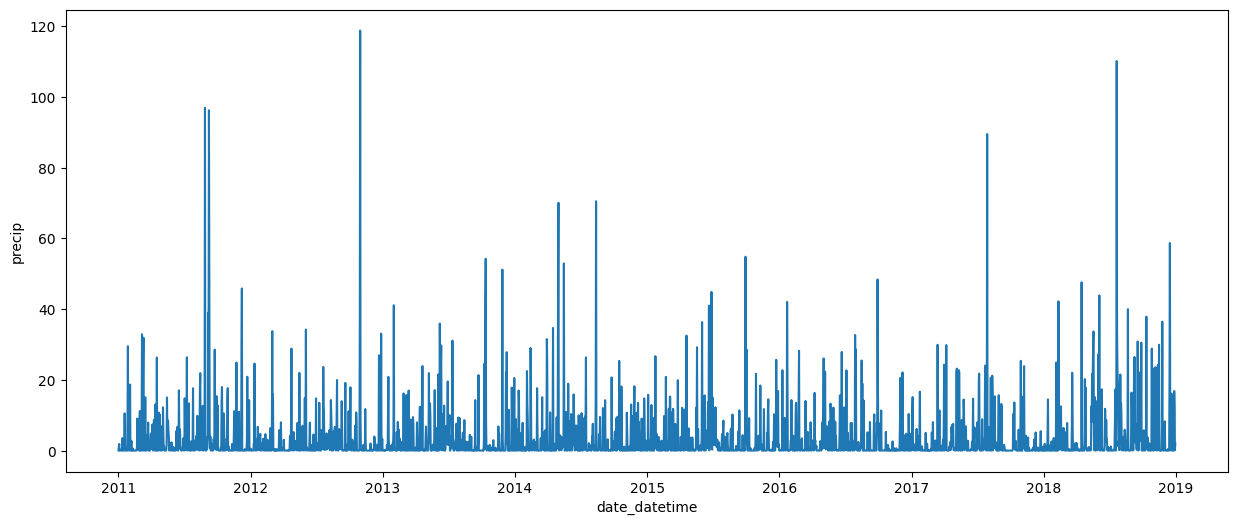

In [54]:
# plot the overall precip values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='precip', data=bike_df)

In [55]:
# get the optimal number for rolling mean window
print(best_window(bike_df['precip'], bike_df['total_cust'], 30))

# correlation for window size determined by precip
precip_mean = bike_df['precip'].rolling(8).mean()[7:-1]
pearsonr(precip_mean, bike_df['total_cust'][8:])

{29: 0.1700866307778595, 1: 0.008462868123957596}


PearsonRResult(statistic=0.08720391472567389, pvalue=2.4247240767198335e-06)

In [56]:
# optimal window for rolling std for precip
print(best_window_std(bike_df['precip'], bike_df['total_cust'], 30))

# correlation for window size determined by precip
precip_mean = bike_df['precip'].rolling(8).std()[7:-1]
pearsonr(precip_mean, bike_df['total_cust'][8:])

{28: 0.08728613813774178, 1: -0.004316064962443652}


PearsonRResult(statistic=0.036881523719282605, pvalue=0.04650923284270452)

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

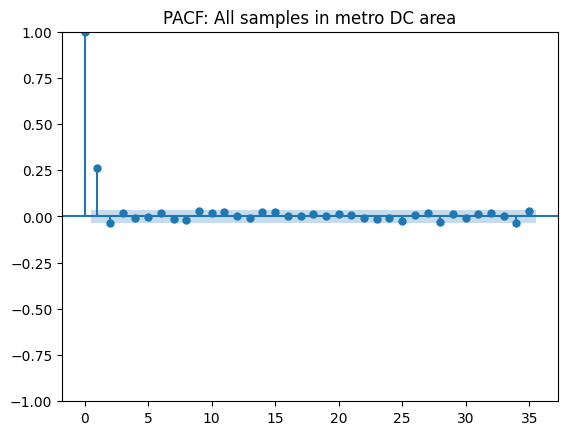

In [57]:
# plot the partial autocorrelation -- precip
plot_pacf(bike_df['precip'], title='PACF: All samples in metro DC area',)
plt.show

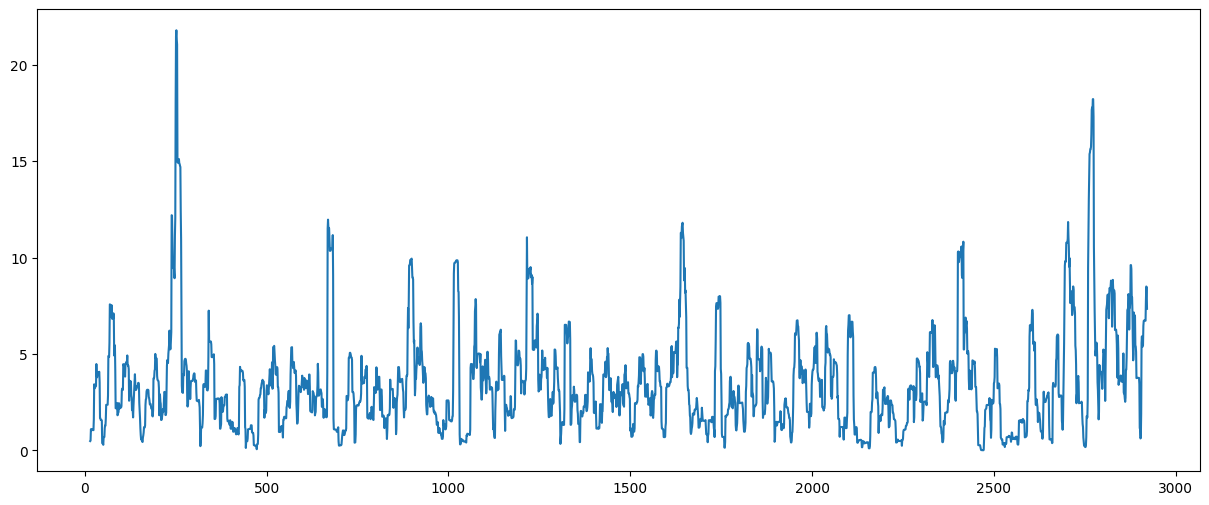

In [58]:
# plot of rolling means -- precipitation
plt.figure(figsize=[15,6])
plt.plot(bike_df['precip'].rolling(16).mean())

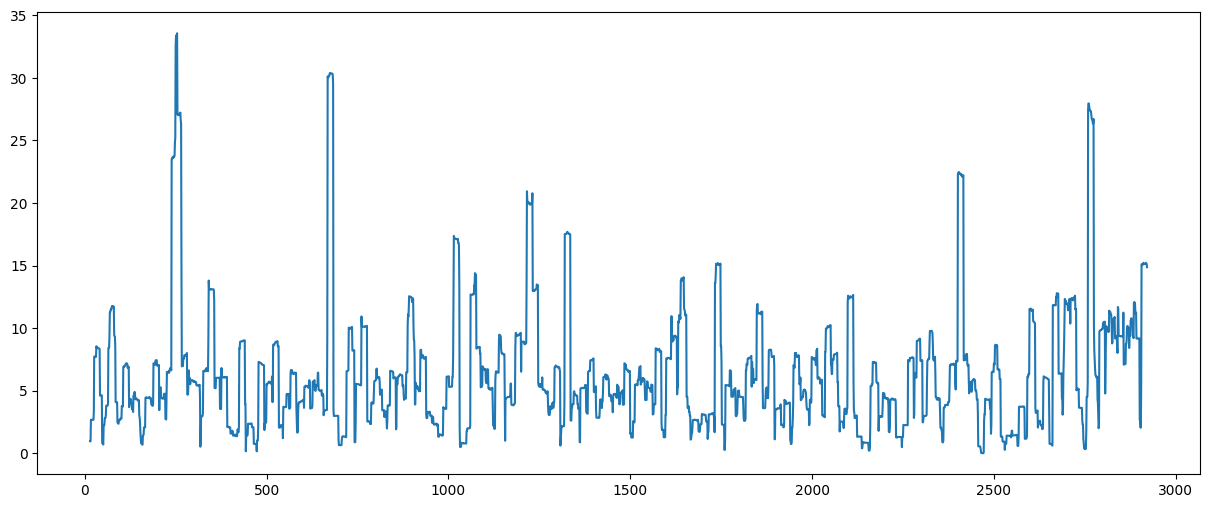

In [59]:
# plot of rolling stds -- precipitation
plt.figure(figsize=[15,6])
plt.plot(bike_df['precip'].rolling(16).std())

Text(0.5, 1.0, 'Wind vs. number of customers')

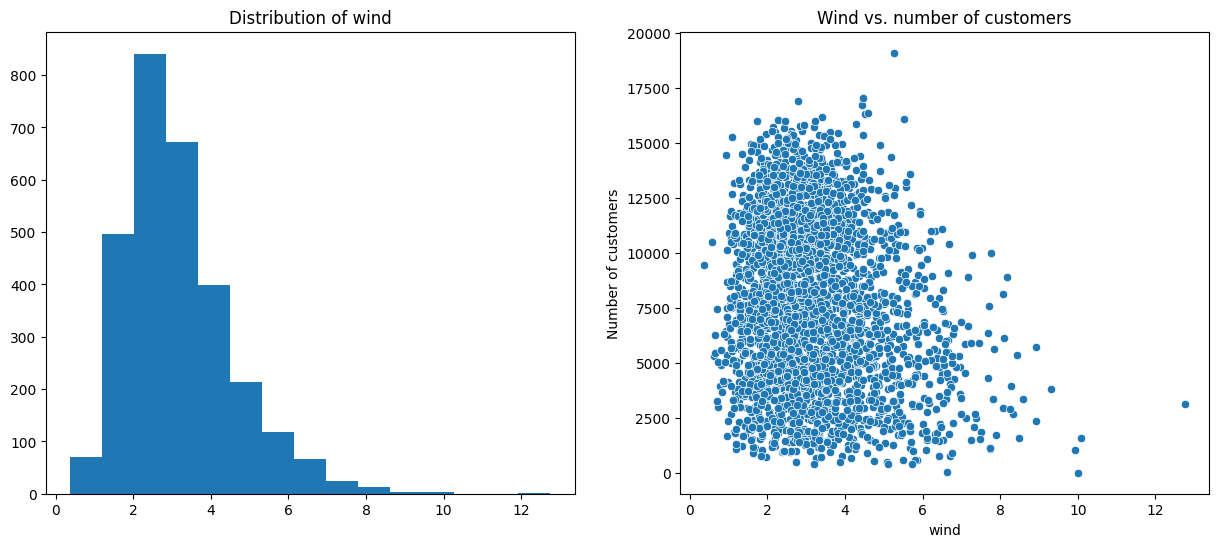

In [60]:
# plotting the distribution of wind
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(bike_df['wind'], bins=15)
plt.title('Distribution of wind')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x='wind', y='total_cust')
plt.xlabel('wind')
plt.ylabel('Number of customers')
plt.title('Wind vs. number of customers')

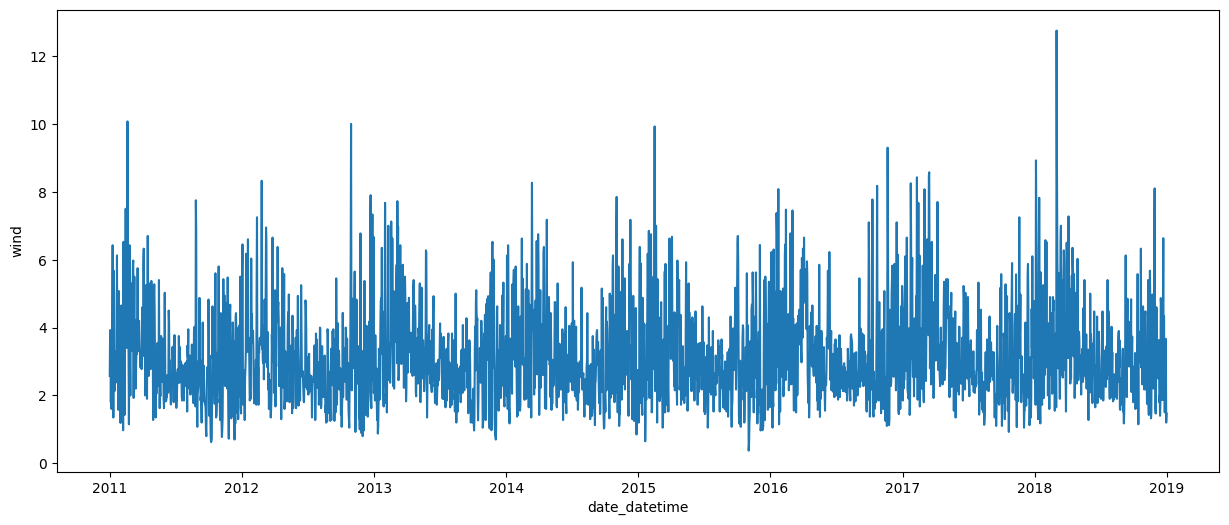

In [61]:
# plot the overall wind values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='wind', data=bike_df)

In [62]:
# optimal number for rollin mean window
print(best_window(bike_df['wind'], bike_df['total_cust'], 30))

# correlation for window size determined by wind
wind_mean = bike_df['wind'].rolling(8).mean()[7:-1]
pearsonr(wind_mean, bike_df['total_cust'][8:])[0]

{29: -0.12193904260296551, 4: -0.17329637853316024}


-0.16774099233635414

In [63]:
# optimal window for rolling std for temperature
print(best_window_std(bike_df['wind'], bike_df['total_cust'], 30))

# correlation for window size determined by wind
percip_mean = bike_df['wind'].rolling(8).std()[7:-1]
pearsonr(precip_mean, bike_df['total_cust'][8:])

{1: -0.2063792748349396, 28: -0.41986595132327353}


PearsonRResult(statistic=0.036881523719282605, pvalue=0.04650923284270452)

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


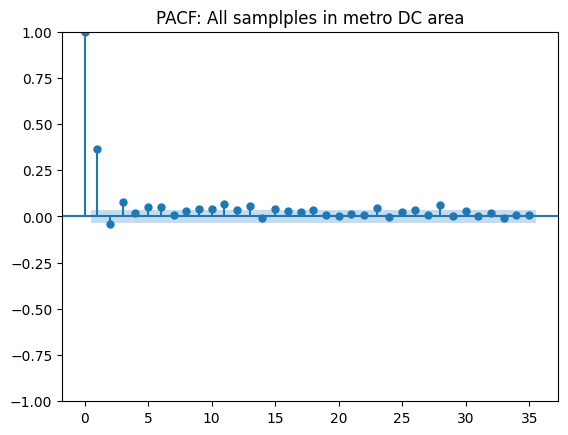

In [64]:
# plot the partial autocorrelation off wind
plot_pacf(bike_df['wind'], title='PACF: All samplples in metro DC area',)
plt.show()

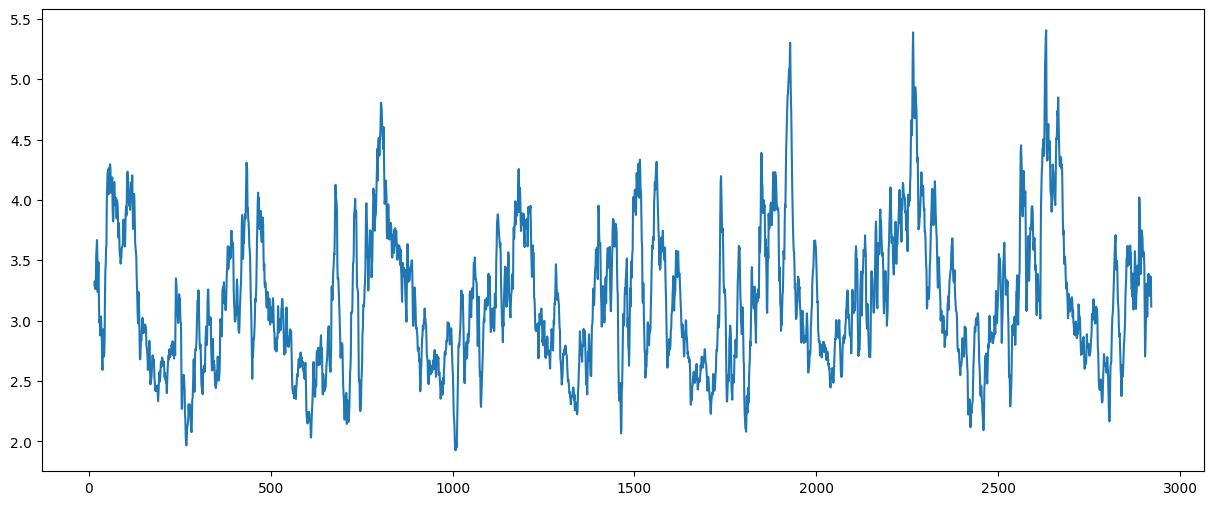

In [65]:
# plot of rolling means -- wind
plt.figure(figsize=[15,6])
plt.plot(bike_df['wind'].rolling(16).mean())

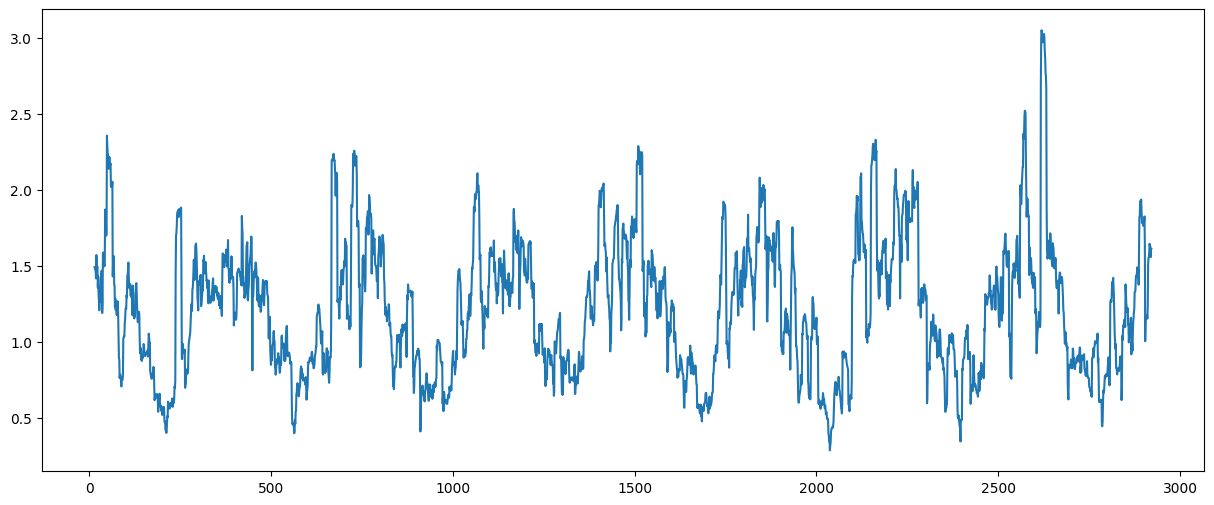

In [66]:
# plot of rolling stds -- wind
plt.figure(figsize=[15,6])
plt.plot(bike_df['wind'].rolling(16).std())

## Checking and dealing with stationarity

In [67]:
# from https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
# Augmented Dickey Fuller Test

def adf_test(df, col_names):
    for name in col_names:
        print('Results of Augmented Dickey-Fuller Test for {}'.format(name))
        result_test = adfuller(df[name], autolag='AIC')
        result_output = pd.Series(result_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key, val in result_test[4].items():
            result_output['Critical Value (%s)'%key] = val
        print(result_output)

In [68]:
# create the feature that need to be tested
# total_cust_t-1 was already added to the dataframe
testing_feat = ['wind', 'precip', 'total_cust', 'temp_min', 'temp_max', 'foggy', 'ice', 'thunder','sleet']
testing_df = pd.DataFrame()

for col in testing_feat:
    col_mean = bike_df[col].rolling(16).mean()[15:-1]
    col_std = bike_df[col].rolling(16).std()[15:-1]
    testing_df[col+'_mean16'] = col_mean.values
    testing_df[col+'_std16'] = col_std.values

In [69]:
# adf test for total_cust_t-1
temp_cust_1 = bike_df['total_cust_t-1'].fillna(0)
bike_df_temp = pd.DataFrame(temp_cust_1, columns=['total_cust_t-1'])
adf_test(bike_df_temp, ['total_cust_t-1'])

Results of Augmented Dickey-Fuller Test for total_cust_t-1
Test Statistic                   -3.085391
p-value                           0.027653
#Lags Used                       22.000000
Number of Observations Used    2899.000000
Critical Value (1%)              -3.432608
Critical Value (5%)              -2.862538
Critical Value (10%)             -2.567301
dtype: float64


In [70]:
# adf test for total_cust
adf_test(bike_df, ['total_cust'])

Results of Augmented Dickey-Fuller Test for total_cust
Test Statistic                   -3.068277
p-value                           0.028992
#Lags Used                       22.000000
Number of Observations Used    2899.000000
Critical Value (1%)              -3.432608
Critical Value (5%)              -2.862538
Critical Value (10%)             -2.567301
dtype: float64


In [71]:
# adf test for all engineered features 
adf_test(testing_df, testing_df.columns)

Results of Augmented Dickey-Fuller Test for wind_mean16
Test Statistic                   -5.565211
p-value                           0.000002
#Lags Used                       28.000000
Number of Observations Used    2877.000000
Critical Value (1%)              -3.432625
Critical Value (5%)              -2.862545
Critical Value (10%)             -2.567305
dtype: float64
Results of Augmented Dickey-Fuller Test for wind_std16
Test Statistic                   -5.043268
p-value                           0.000018
#Lags Used                       17.000000
Number of Observations Used    2888.000000
Critical Value (1%)              -3.432616
Critical Value (5%)              -2.862541
Critical Value (10%)             -2.567303
dtype: float64
Results of Augmented Dickey-Fuller Test for precip_mean16
Test Statistic                -8.653592e+00
p-value                        5.038219e-14
#Lags Used                     2.700000e+01
Number of Observations Used    2.878000e+03
Critical Value (1%)    

## Kwiatkowski-Phillips-Schmidt-Shin Test  

In [72]:
# from https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

def kpss_test(df, col_names):
    for name in col_names:
        print('Results of KPSS Test for {}'.format(name))
        result_test = kpss(df[name], regression='c', nlags='legacy')
        result_output = pd.Series(result_test[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
        for key, val in result_test[3].items():
            result_output['Critical Value (%s)' %key] = val
        print(result_output)

# kpss test for total cust
kpss_test(testing_df, testing_df.columns)

Results of KPSS Test for wind_mean16
Test Statistic            0.361757
p-value                   0.093639
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for wind_std16
Test Statistic            0.066393
p-value                   0.100000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for precip_mean16
Test Statistic            0.190685
p-value                   0.100000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for precip_std16
Test Statistic            0.12816
p-value                   0.10000
La

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test stati

In [73]:
# kpss test for total_cust_t-1
kpss_test(bike_df_temp, ['total_cust_t-1'])
# kpss test for total_cust
kpss_test(bike_df, ['total_cust'])

Results of KPSS Test for total_cust_t-1
Test Statistic            4.452604
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for total_cust
Test Statistic            4.430839
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [74]:
# Removing positive upward trend from total_cust_mean, total_cust_std16 and total_cust_t-1
testing_df['total_cust_std16_log'] = [np.log1p(x+1) for x in testing_df['total_cust_std16']]
testing_df['total_cust_mean16_log'] = [np.log1p(x+1) for x in testing_df['total_cust_mean16']]
bike_df_temp['total_cust_t-1_log'] = [np.log1p(x+1) for x in bike_df_temp['total_cust_t-1']]


## Differencing

In [75]:
# applying differencing to remove trend from total_cust
bike_df_check = bike_df[['total_cust']]
bike_df_check['total_cust_diff'] = bike_df_check['total_cust'] - bike_df_check['total_cust'].shift()
bike_df_check = bike_df_check.iloc[1:,]

/tmp/ipykernel_6094/4231989867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_df_check['total_cust_diff'] = bike_df_check['total_cust'] - bike_df_check['total_cust'].shift()


In [76]:
#  kpss test for total_cust
kpss_test(testing_df, ['total_cust_std16_log', 'total_cust_mean16_log'])
kpss_test(bike_df_temp, ['total_cust_t-1_log'])

# adf test for total_cust
adf_test(testing_df, ['total_cust_std16_log', 'total_cust_mean16_log'])
adf_test(bike_df_temp, ['total_cust_t-1_log'])
adf_test(bike_df_check, ['total_cust_diff'])

Results of KPSS Test for total_cust_std16_log
Test Statistic            6.328651
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for total_cust_mean16_log
Test Statistic            4.412647
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for total_cust_t-1_log
Test Statistic            4.013791
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Augmented Dickey-Fuller Test for total_cust_std16_log


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic                   -4.578370
p-value                           0.000142
#Lags Used                       16.000000
Number of Observations Used    2889.000000
Critical Value (1%)              -3.432616
Critical Value (5%)              -2.862541
Critical Value (10%)             -2.567303
dtype: float64
Results of Augmented Dickey-Fuller Test for total_cust_mean16_log
Test Statistic                   -3.959044
p-value                           0.001641
#Lags Used                       28.000000
Number of Observations Used    2877.000000
Critical Value (1%)              -3.432625
Critical Value (5%)              -2.862545
Critical Value (10%)             -2.567305
dtype: float64
Results of Augmented Dickey-Fuller Test for total_cust_t-1_log
Test Statistic                   -3.902610
p-value                           0.002016
#Lags Used                       26.000000
Number of Observations Used    2895.000000
Critical Value (1%)              -3.432611
Critical Value (5%)     

## 2.6 Feature Selection
Based on above EDA the following features will be included in the model

    holiday: t0
    weekdays: each day at t0
    workingday: t0
    temp_max: rolling mean for 8 
    temp_max: rolling std for 8 days
    temp_min:rolling mean for 8 days
    temp_min: rolling std for 8 days
    season_spring: t0
    season_summer: t0
    season_fall: t0
    very cold, cold, cool, warm, hot: t-1
    foggy, thunder, ice, sleet: rolling mean and std for 8 days
    wind: rolling mean for 8 days
    wind: rolling std for 8 days
    precip: rolling mean for 8 days
    precip: rolling std for 8 days
    total_cust: t-1
    total_cust: rolling mean for 8 days
    total_cust: rolling std for 8 days


## 3. Data Preparation

In [77]:
# Dropping unnecessary columns
# shoudl keep this before the  cleaning function has been created
bike_df.drop(columns=['temp_observ', 'weekday'], axis=1, inplace=True)
# drop the timestamp variable
bike_df.drop(columns=['date_datetime'], inplace=True)

In [78]:
# 3.2 Creating new features
# specify the window for rolling values
window = 8

# engineer new categorical temp features
bike_df_cat = bike_df[['temp_max']].copy()
bike_df_cat['very_cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 0 else 0)
bike_df_cat['cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 10 and x >= 0 else 0)
bike_df_cat['cool'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 20 and x >= 10 else 0)
bike_df_cat['warm'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 30 and x >= 20 else 0)
bike_df_cat['hot'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x >= 30 else 0)

bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']] = bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']].shift()
bike_df_cat.drop(columns=['temp_max'], inplace=True)

# creating rolling values
new_feat = ['wind', 'precip', 'total_cust', 'temp_max', 'temp_min', 'foggy', 'ice', 'thunder','sleet']
temp_df = pd.DataFrame()

for col in new_feat:
    col_mean = bike_df[col].rolling(window).mean()[(window-1):-1]
    col_std = bike_df[col].rolling(window).std()[(window-1):-1]
    temp_df[col + '_mean'+str(window)] = col_mean.values
    temp_df[col+'_std'+str(window)] = col_std.values

# remove the first row from 16 rows from total_cust (target label)
new_bike_df = bike_df.iloc[window:, :]
bike_df_cat = bike_df_cat.iloc[window:,:]
new_bike_df.reset_index(drop=True, inplace=True)
bike_df_cat.reset_index(drop=True, inplace=True)
new_bike_df.head()

temp_min  temp_max    precip   wind  total_cust  holiday  season_spring  \
0 -6.293333  0.226667  0.283529  6.425       802.0      0.0              1   
1 -6.238462  0.507692  0.000000  2.975      1298.0      0.0              1   
2 -5.914286  0.564286  0.460241  1.350      1231.0      0.0              1   
3 -5.114286  0.192857  3.526882  5.675      1141.0      0.0              1   
4 -4.600000  1.035714  0.000000  5.025      1383.0      0.0              1   

   season_summer  season_fall  weekday_1  ...  weekday_3  weekday_4  \
0              0            0          0  ...          0          0   
1              0            0          0  ...          0          0   
2              0            0          1  ...          0          0   
3              0            0          0  ...          0          0   
4              0            0          0  ...          1          0   

   weekday_5  weekday_6  working_day  foggy  thunder  ice  sleet  \
0          0          1          0.0      1      0.0    0      0   
1          0          0          0.0      1      0.0    0      0   
2          0          0          1.0      1      0.0    1      1   
3          0          0          1.0      1      0.0    0      1   
4          0          0          1.0      1      0.0    0      0   

   total_cust_t-1  
0           939.0  
1           802.0  
2          1298.0  
3          1231.0  
4          1141.0  

[5 rows x 21 columns]

In [79]:
# drop all columns which we cannot use because of lookahead bias
new_bike_df.drop(columns=['temp_max', 'wind', 'temp_min', 'precip', 'thunder', 'foggy', 'ice', 'sleet'], inplace=True)

# merging both dataframes with features
final_bike_df = new_bike_df.join(temp_df, how='left')
final_bike_df = final_bike_df.join(bike_df_cat, how='left')
final_bike_df.head()

/tmp/ipykernel_6094/3879898264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bike_df.drop(columns=['temp_max', 'wind', 'temp_min', 'precip', 'thunder', 'foggy', 'ice', 'sleet'], inplace=True)


total_cust  holiday  season_spring  season_summer  season_fall  weekday_1  \
0       802.0      0.0              1              0            0          0   
1      1298.0      0.0              1              0            0          0   
2      1231.0      0.0              1              0            0          1   
3      1141.0      0.0              1              0            0          0   
4      1383.0      0.0              1              0            0          0   

   weekday_2  weekday_3  weekday_4  weekday_5  ...  ice_std8  thunder_mean8  \
0          0          0          0          0  ...  0.353553            0.0   
1          0          0          0          0  ...  0.353553            0.0   
2          0          0          0          0  ...  0.353553            0.0   
3          1          0          0          0  ...  0.462910            0.0   
4          0          1          0          0  ...  0.462910            0.0   

   thunder_std8  sleet_mean8  sleet_std8  very_cold  cold  cool  warm  hot  
0           0.0        0.375    0.517549        0.0   1.0   0.0   0.0  0.0  
1           0.0        0.375    0.517549        0.0   1.0   0.0   0.0  0.0  
2           0.0        0.375    0.517549        0.0   1.0   0.0   0.0  0.0  
3           0.0        0.500    0.534522        0.0   1.0   0.0   0.0  0.0  
4           0.0        0.625    0.517549        0.0   1.0   0.0   0.0  0.0  

[5 rows x 36 columns]

In [80]:
# 3.3 Assigning X and y
y = final_bike_df['total_cust']
X = final_bike_df.drop(columns=['total_cust'])

## 4. Model

In [81]:
# creating transformation classes
class Debug(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        self.shape = X.shape
        print(self.shape)
        X_df = pd.DataFrame(X)
        print(X_df)
        #  print(X_df.to_string())  # can only be print like this withour running LagVars() to avoid crash
        # what other output you want
        return X

# 4.2 Baseline model: naive univariate prediction
# assigning X and y for the univariate naive prediction
y_naive = (final_bike_df['total_cust'].copy())
X_naive = y_naive.copy()
X_naive = pd.DataFrame(data=X_naive, columns=['total_cust'])

# getting the start time
start_time = datetime.now()

# creating y_pred
y_pred = (X_naive.shift())[1:]
# adjusting length of the actual target values
y_naive = y_naive[1:]

# get  final time
end_time = datetime.now()
print('Total running time of naive predictor:', (end_time - start_time).total_seconds())

# calculating the scorees for the last value method
print('RMS:', np.sqrt(mean_squared_error(y_naive, y_pred)))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_naive, y_pred)))
print('MAE:', mean_absolute_error(y_naive, y_pred))


Total running time of naive predictor: 0.000256
RMS: 2092.6809614099934
RMSLE: 0.40731742102103863
MAE: 1403.2437349811191


## preparation code -- using differenced y for predictions


In [82]:
y_log = final_bike_df[['total_cust']].copy()
y_log['total_cust'] = y_log['total_cust'].apply(lambda x: np.log1p(x+1))
y_shift = y_log.shift(1)
y_diff = (y_log - y_shift)[1:]
X_diff = X[1:]

y_diff.reset_index(drop=True, inplace =True)
X_diff.reset_index(drop=True, inplace=True)

# initializing Random Forest model using default hyperparameters
model_rf_diff = RandomForestRegressor(random_state=42)

# creating and fitting the ML pipeline
trend_features = ['total_cust_mean' + str(window), 'total_cust_std'+str(window), 'total_cust_t-1']
preprocessor = ColumnTransformer([('trend_diff', FunctionTransformer(np.log1p, validate=False),trend_features),], remainder='passthrough')
pipeline = Pipeline([('preprocessor', preprocessor),('model', model_rf_diff)]) #('debug', Debug()) # not included, it hinder the execution of this pipeline
pipeline_rf_diff = pipeline.fit(X_diff, y_diff)

# creating a timeseries split of the dataset
time_split = TimeSeriesSplit(n_splits=10)

# cross validation of splits and score calculation
scores_rf_diff = cross_validate(pipeline_rf_diff, X_diff, y_diff, cv=time_split, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], return_train_score=True, n_jobs=-1)

# root mean squared error
print('Average RMSE train data:', sum([np.sqrt(-1 * x) for x in scores_rf_diff['train_neg_mean_squared_error']])/len(scores_rf_diff['train_neg_mean_squared_error']))
print('Average RMSE test data:', sum([np.sqrt(-1 * x) for x in scores_rf_diff['test_neg_mean_squared_error']])/len(scores_rf_diff['test_neg_mean_squared_error']))

# mean absolute error
print('Average MAE train data:', sum([(-1 * x) for x in scores_rf_diff['train_neg_mean_absolute_error']])/len(scores_rf_diff['train_neg_mean_absolute_error']))
print('Average MAE test data:', sum([(-1 * x) for x in scores_rf_diff['test_neg_mean_absolute_error']])/len(scores_rf_diff['test_neg_mean_absolute_error']))


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/pip

Average RMSE train data: 0.13254412204057067
Average RMSE test data: 0.3877538755135256
Average MAE train data: 0.07924185931103389
Average MAE test data: 0.27507221596449083


In [83]:
# getting indices for all folds from timeseries split
X_train_over = defaultdict()
X_test_over = defaultdict()
y_train_over = defaultdict()
y_test_over = defaultdict()

y_test_index = []
y_train_index = []

count = 0

for train_index, test_index in time_split.split(X_diff):
    print('TRAIN:', train_index, 'TEST:', test_index)

    y_test_index.append(test_index)
    y_train_index.append(train_index)

    X_train, X_test = X_diff.iloc[train_index], X_diff.iloc[test_index]
    y_train, y_test = (np.array(y_diff))[train_index], (np.array(y_diff))[test_index]
    X_train_over[count] = X_train
    X_test_over[count] = X_test
    y_train_over[count] = y_train
    y_test_over[count] = y_test

    count += 1



TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [84]:
def split_predict_test(X_train, y_train, X_test, y_test, split):
    pipeline_part = pipeline.fit(X_train[split], y_train[split].ravel())
    prediction_test = pipeline_part.predict(X_test[split])
    #print('transformedRMSE:', np.sqrt(mean_squared_error(y_test[split], prediction_test)))

    # what are the predictions in absolute terms
    y_test_pred_log = prediction_test + y_log.iloc[y_test_index[split]]['total_cust']
    y_test_pred = np.exp(y_test_pred_log) - 2

    # what are the actual values in absolute terms
    y_test_true_log  = y_test[split] + y_log.iloc[y_test_index[split]]
    y_test_true = np.exp(y_test_true_log) - 2  # minus 2 because we added 1 each when doing the e log function earlier

    # what is the RMSE, RMSLE and MAE
    #print('actual RMSE:', np.sqrt(mean_squared_error(y_test_true, y_test_pred)))
    #print('actual RMSLE:', np.sqrt(mean_squared_log_error(y_test_true, y_test_pred)))
    #print('actual MAE:', mean_absolute_error(y_test_true, y_test_pred))

    rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_test_true, y_test_pred))
    mae = mean_absolute_error(y_test_true, y_test_pred)

    list_scores = []
    list_scores.extend([rmse, rmsle, mae])

    return list_scores

    

def split_predict_train(X_train, y_train, X_test, y_test, split):
    
    pipeline_part = pipeline.fit(X_train[split], y_train[split].ravel())
    prediction_train = pipeline_part.predict(X_train[split])
    #print('transformed RMSE:', np.sqrt(mean_squared_error(y_test[split], prediction_test)))
        
    # what are the predictions in absolute terms
    y_train_pred_log = prediction_train + y_log.iloc[y_train_index[split]]['total_cust']
    y_train_pred = np.exp(y_train_pred_log) - 2

    # what are the actual values in absolute terms
    y_train_true_log = y_train[split] + y_log.iloc[y_train_index[split]]
    y_train_true = np.exp(y_train_true_log) - 2 # minus 2 because we added 1 each when doing the log function earlier

    # what is the rmse, rmsle and mae
    #print('actual RMSE:', np.sqrt(mean_squared_error(y_test_true, y_test_pred)))
    #print('actual RMSLE:', np.sqrt(mean_squared_log_error(y_test_true, y_test_pred)))
    #print('actual MAE:', mean_absolute_error(y_test_true, y_test_pred))
    
    rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_train_true, y_train_pred))
    mae = mean_absolute_error(y_train_true, y_train_pred)
    
    list_scores = []
    list_scores.extend([rmse, rmsle, mae])
    
    return list_scores

## 4.4 Random Forests

In [85]:
# code is exactly the same as preparation code just using scores_rf vs. scores_rf_diff

# model with untransformed y
# initializing Random Forest model using default hyperparameters
model_rf = RandomForestRegressor(bootstrap=False, random_state=15)

# creating and fitting the ML pipeline
trend_features = ['total_cust_mean' + str(window), 'total_cust_std' + str(window), 'total_cust_t-1']
preprocessor = ColumnTransformer([('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),], remainder='passthrough')
pipeline = Pipeline([('preprocessor', preprocessor),('model', model_rf)])
pipeline_rf = pipeline.fit(X,y)

# creating a timeseries plit of the dataset
time_split = TimeSeriesSplit(n_splits=10)

# cross validation of splits and score calculation
scores_rf = cross_validate(pipeline_rf, X, y, cv=time_split,
                        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_squared_log_error'],
                        return_train_score=True, n_jobs=-1)

# root mean squared error 
print('Random Forests: Average RMSE train data:',
                    sum([np.sqrt(-1 * x) for x in scores_rf['train_neg_mean_squared_error']])/
                                len(scores_rf['train_neg_mean_squared_error']))
print('Random Forests: Average RMSE test data:',
                    sum([np.sqrt(-1 * x) for x in scores_rf['test_neg_mean_squared_error']])/
                                len(scores_rf['test_neg_mean_squared_error']))

# mean absolute error
print('Random Forests: Average MAE train data', 
                    sum([(-1 * x) for x in scores_rf['train_neg_mean_absolute_error']])/
                                len(scores_rf['train_neg_mean_absolute_error']))
print('Random Forests: Average MAE test data:', sum([(-1 *x) for x in scores_rf['test_neg_mean_absolute_error']])/len(scores_rf['test_neg_mean_absolute_error']))

# root mean squared log error
print('Random Forests: Average RMSLE train data:',
                    sum([(-1 * x) for x in scores_rf['train_neg_mean_squared_log_error']])/
                                len(scores_rf['train_neg_mean_squared_log_error']))
print('Random Forests: Average RMSLE test data:',
                    sum([(-1 * x) for x in scores_rf['test_neg_mean_squared_log_error']])/
                                len(scores_rf['test_neg_mean_squared_log_error']))



Random Forests: Average RMSE train data: 0.0
Random Forests: Average RMSE test data: 3004.5517203487634
Random Forests: Average MAE train data 0.0
Random Forests: Average MAE test data: 2311.533837121212
Random Forests: Average RMSLE train data: 0.0
Random Forests: Average RMSLE test data: 0.2933674724834663


In [86]:
# tuning RF hyperparameters using randomizedsearch and gridsearch

# number of trees in random forest
n_estimators = randint(1,2000)
#maximum number of features included in the model
max_features = randint(1, 20)
# maximum number of levels in tree
max_depth = randint(1, 10)
# minimum number o samples requreied to split a node
min_samples_leaf = randint(1, 10)

# create the random grid
random_grid_rf = {'model__n_estimators': n_estimators,
                  'model__max_depth': max_depth,
                  'model__min_samples_leaf': min_samples_leaf,
                  'model__max_features': max_features}

# check start time
start_time = datetime.now()
print(start_time)

# instantiate and fit the  randomizedsearch class to the random parameters
rs_rf = RandomizedSearchCV(pipeline_rf, param_distributions=random_grid_rf, scoring='neg_mean_squared_error', n_jobs=-1, cv=time_split, n_iter = 5, verbose=10, random_state=49)
rs_rf = rs_rf.fit(X,y)

# print the total running time
end_time = datetime.now()
print('Total running time:', end_time-start_time)


2023-02-04 10:46:39.615148
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 3/10; 2/5] START model__max_depth=2, model__max_features=19, model__min_samples_leaf=5, model__n_estimators=1677
[CV 4/10; 2/5] START model__max_depth=2, model__max_features=19, model__min_samples_leaf=5, model__n_estimators=1677
[CV 5/10; 2/5] START model__max_depth=2, model__max_features=19, model__min_samples_leaf=5, model__n_estimators=1677
[CV 6/10; 2/5] START model__max_depth=2, model__max_features=19, model__min_samples_leaf=5, model__n_estimators=1677
[CV 7/10; 2/5] START model__max_depth=2, model__max_features=19, model__min_samples_leaf=5, model__n_estimators=1677
[CV 8/10; 2/5] START model__max_depth=2, model__max_features=19, model__min_samples_leaf=5, model__n_estimators=1677
[CV 9/10; 2/5] START model__max_depth=2, model__max_features=19, model__min_samples_leaf=5, model__n_estimators=1677
[CV 10/10; 2/5] START model__max_depth=2, model__max_features=19, model__min_samples_leaf=5, 

In [87]:
# save best RF model
pickle.dump(rs_rf.best_estimator_, open('randomforest.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_rf = {key[7:]: val for key, val in rs_rf.best_params_.items()}
print(fix_best_params_rf)

# fit the randomforestregressor with the best_params as hyperparameters
model_rf_rs = RandomForestRegressor(**fix_best_params_rf, bootstrap=False)


{'max_depth': 9, 'max_features': 19, 'min_samples_leaf': 6, 'n_estimators': 1926}


In [88]:
# creating and  fitting the ML pipeline randomizedSearch
trend_features = ['total_cust_mean' + str(window), 'total_cust_std' + str(window), 'total_cust_t-1']
preprocessor = ColumnTransformer([('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features), ], remainder='passthrough')
pipeline = Pipeline([('preprocessor', preprocessor), ('model', model_rf_rs)])

# fitting X and y to pipeline
pipeline_rf_rs = pipeline.fit(X,y)

# cross validation on splits and calculating scores
scores_rf = cross_validate(pipeline_rf_rs, X, y, cv=time_split, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_squared_log_error'], return_train_score=True, n_jobs=-1)

# root mean squared error
print('Random Forests: Average RMSE train data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf['train_neg_mean_squared_error']])/len(scores_rf['train_neg_mean_squared_error']))
print('Random Forests: Average RMSE test data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf['test_neg_mean_squared_error']])/len(scores_rf['test_neg_mean_squared_error']))

# absolute mean error
print('Random Forests: Average MAE train data:', 
      sum([(-1 * x) for x in scores_rf['train_neg_mean_absolute_error']])/len(scores_rf['train_neg_mean_absolute_error']))
print('Random Forests: Average MAE test data:', 
      sum([(-1 * x) for x in scores_rf['test_neg_mean_absolute_error']])/len(scores_rf['test_neg_mean_absolute_error']))

# root mean squared log error
print('Random Forests: Average RMSLE train data:', 
      sum([(-1 * x) for x in scores_rf['train_neg_mean_squared_log_error']])/len(scores_rf['train_neg_mean_squared_log_error']))
print('Random Forests: Average RMSLE test data:', 
      sum([(-1 * x) for x in scores_rf['test_neg_mean_squared_log_error']])/len(scores_rf['test_neg_mean_squared_log_error']))

Random Forests: Average RMSE train data: 780.1083606285179
Random Forests: Average RMSE test data: 2005.405585236506
Random Forests: Average MAE train data: 542.6887208243745
Random Forests: Average MAE test data: 1571.7378071541114
Random Forests: Average RMSLE train data: 0.06555683237888296
Random Forests: Average RMSLE test data: 0.13595699408222092


In [89]:
# assign list of parameters to be used in gridsearch
param_grid_rf = {'model__max_depth': [8,9],
                    'model__max_features': [18,19],
                    'model__min_samples_leaf': [5,6],
                    'model__n_estimators': [1926,1930]}
# use gridsearch to search around the randomizedsearch best parameters and further improve the model
gs_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1,cv=time_split)
gs_rf = gs_rf.fit(X,y)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10; 1/16] START model__max_depth=8, model__max_features=18, model__min_samples_leaf=5, model__n_estimators=1926
[CV 2/10; 1/16] START model__max_depth=8, model__max_features=18, model__min_samples_leaf=5, model__n_estimators=1926
[CV 3/10; 1/16] START model__max_depth=8, model__max_features=18, model__min_samples_leaf=5, model__n_estimators=1926
[CV 4/10; 1/16] START model__max_depth=8, model__max_features=18, model__min_samples_leaf=5, model__n_estimators=1926
[CV 5/10; 1/16] START model__max_depth=8, model__max_features=18, model__min_samples_leaf=5, model__n_estimators=1926
[CV 6/10; 1/16] START model__max_depth=8, model__max_features=18, model__min_samples_leaf=5, model__n_estimators=1926
[CV 7/10; 1/16] START model__max_depth=8, model__max_features=18, model__min_samples_leaf=5, model__n_estimators=1926
[CV 8/10; 1/16] START model__max_depth=8, model__max_features=18, model__min_samples_leaf=5, model__n_estimator

In [90]:
# saving the best RadomForest model
pickle.dump(gs_rf.best_estimator_, open('randomforest.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_rf = {key[7:]: val for key, val in gs_rf.best_params_.items()}
print(fix_best_params_rf)

# fit the randomforestregressor with te best_params as hyperparameters
model_rf_tuned = RandomForestRegressor(**fix_best_params_rf, bootstrap=False)

{'max_depth': 8, 'max_features': 19, 'min_samples_leaf': 6, 'n_estimators': 1926}


In [91]:
# creating and fitting the ML pipeline -- tuned model
trend_features = ['total_cust_mean' + str(window), 'total_cust_std' + str(window), 'total_cust_t-1']
preprocessor = ColumnTransformer([('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),], remainder='passthrough')
pipeline = Pipeline([('preprocessor', preprocessor), ('model', model_rf_tuned)])
# fitting X and y to pipeline
pipeline_rf_tuned = pipeline.fit(X,y)

# check the start time
start_time = datetime.now()
# cross validation on splits and calculating scores
scores_rf_tuned = cross_validate(pipeline_rf_tuned, X, y, cv=time_split, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_squared_log_error'], return_train_score=True, n_jobs=-1)
# print the total running time
end_time = datetime.now()
print('Total cross validation time for random forests:', (end_time-start_time).total_seconds())

Total cross validation time for random forests: 16.69862


In [92]:
# root mean squared error
print('Random Forests: Average RMSE train data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_tuned['train_neg_mean_squared_error']])/len(scores_rf_tuned['train_neg_mean_squared_error']))
print('Random Forests: Average RMSE test data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_tuned['test_neg_mean_squared_error']])/len(scores_rf_tuned['test_neg_mean_squared_error']))

# mean absolute error
print('Random Forests: Average MAE train data:', 
      sum([(-1 * x) for x in scores_rf_tuned['train_neg_mean_absolute_error']])/len(scores_rf_tuned['train_neg_mean_absolute_error']))
print('Random Forests: Average MAE test data:', 
      sum([(-1 * x) for x in scores_rf_tuned['test_neg_mean_absolute_error']])/len(scores_rf_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('Random Forests: Average RMSLE train data:', 
      sum([(-1 * x) for x in scores_rf_tuned['train_neg_mean_squared_log_error']])/len(scores_rf_tuned['train_neg_mean_squared_log_error']))
print('Random Forests: Average RMSLE test data:', 
      sum([(-1 * x) for x in scores_rf_tuned['test_neg_mean_squared_log_error']])/len(scores_rf_tuned['test_neg_mean_squared_log_error']))

Random Forests: Average RMSE train data: 837.369592616936
Random Forests: Average RMSE test data: 2003.0774469122923
Random Forests: Average MAE train data: 588.2124182847263
Random Forests: Average MAE test data: 1571.326227047879
Random Forests: Average RMSLE train data: 0.07061130237313004
Random Forests: Average RMSLE test data: 0.1356841664655355


<AxesSubplot: >

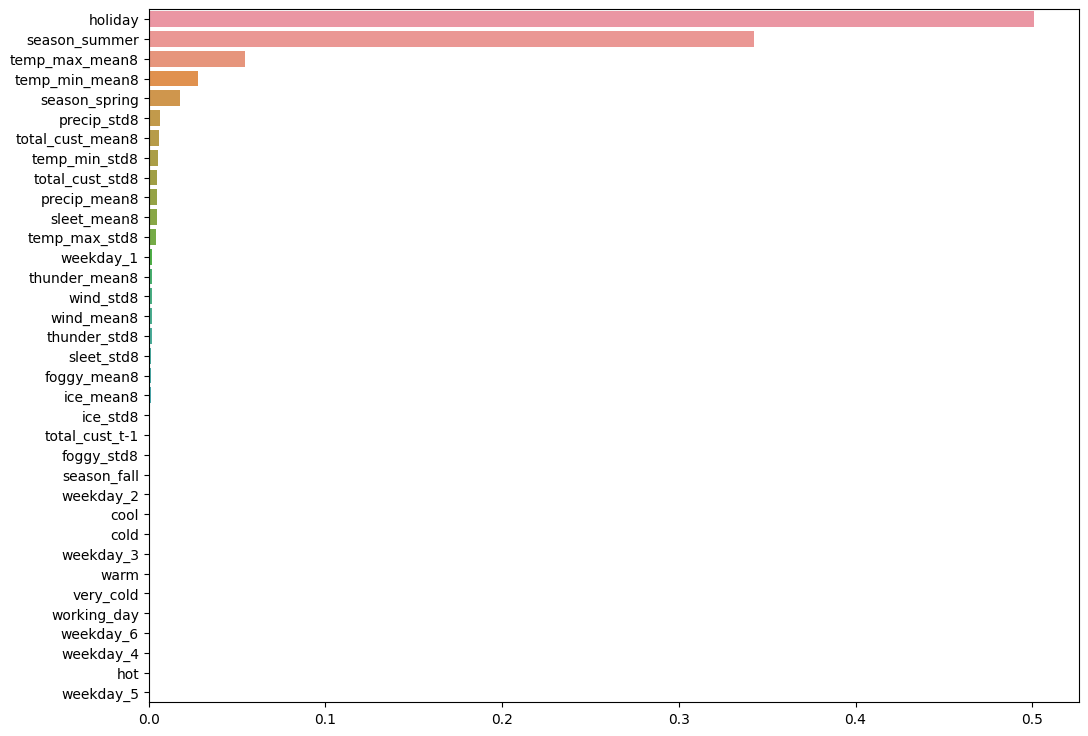

In [93]:
# plot feature importance
plt.figure(figsize=[12,9])
importances = list(pipeline_rf_tuned.steps[1][1].feature_importances_)

imp_dict = {key: val for key, val in zip(list(X.columns), importances)}
sorted_feats = sorted(imp_dict.items(), key=lambda x:x[1], reverse=True)
x_val = [x[0] for x in sorted_feats]
y_val = [x[1] for x in sorted_feats]

sb.barplot(x = y_val, y = x_val)

## running model with differenced y

In [94]:
# final scores for the differenced data
split = 10
all_scores_test = []
all_scores_train = []

for i in range(split):
    scores_test = split_predict_test(X_train_over, y_train_over, X_test_over, y_test_over, i)
    all_scores_test. append(scores_test)
    scores_train = split_predict_train(X_train_over, y_train_over, X_test_over, y_test_over, i)
    all_scores_train.append(scores_train)

rmse_test = []
rmsle_test =[]
mae_test = []
rmse_train = []
rmsle_train = []
mae_train = []

for vals in all_scores_test:
    rmse_test.append(vals[0])
    rmsle_test.append(vals[1])
    mae_test.append(vals[2])

for vals in all_scores_train:
    rmse_train.append(vals[0])
    rmsle_train.append(vals[1])
    mae_train.append(vals[2])

print('Overall Test RMSE:', sum(rmse_test)/split)
print('Overall Test RMSLE:', sum(rmsle_test)/split)
print('Overall Test MAE:', sum(mae_test)/split)

print('Overall Tarin RMSE:', sum(rmse_train)/split)
print('Overall Train RMSLE:', sum(rmsle_train)/split)
print('Overall Train MAE:', sum(mae_train)/split)


Overall Test RMSE: 2024.7642670428406
Overall Test RMSLE: 0.3682110008012457
Overall Test MAE: 1534.184578739163
Overall Tarin RMSE: 1100.2576084546474
Overall Train RMSLE: 0.27347737133195954
Overall Train MAE: 779.7509137764798


In [95]:
# feature removal based on importance

# how many features are in the dataset currently
len(x_val)
weekday_feats = ['weekday_3', 'weekday_1', 'weekday_2', 'weekday_4', 'weekday_5', 'weekday_6']
# check model performance w/o unimportant features
X_feat_imp = X.drop(columns=weekday_feats)

# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window)]#, 'total_cust_t-1']

preprocessor = ColumnTransformer([('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),], remainder='passthrough')
pipeline = Pipeline([('preprocessor', preprocessor), ('model', model_rf_tuned)])

# fitting x and y to pipeline
pipeline_rf_tuned = pipeline.fit(X_feat_imp, y)

# cross validation and calculating score
scores_rf_tuned = cross_validate(pipeline_rf_tuned, X_feat_imp, y, cv=time_split, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'], return_train_score=True, n_jobs=-1)



# root mean squared error
print('Random Forests: Average RMSE train data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_tuned['train_neg_mean_squared_error']])/
                        len(scores_rf_tuned['train_neg_mean_squared_error']))
print('Random Forests: Average RMSLE test data:', 
      sum([np.sqrt(-1 * x) for x in scores_rf_tuned['test_neg_mean_squared_error']])/
                        len(scores_rf_tuned['test_neg_mean_squared_error']))

# mean absolute error
print('Random Forests: Average MAE train data:', 
      sum([(-1 * x) for x in scores_rf_tuned['train_neg_mean_absolute_error']])/
                        len(scores_rf_tuned['train_neg_mean_absolute_error']))
print('Random Forests: Average MAE test data:', 
      sum([(-1 * x) for x in scores_rf_tuned['test_neg_mean_absolute_error']])/
                        len(scores_rf_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('Random Forests: Average RMSLE train data:', 
      sum([(-1 * x) for x in scores_rf_tuned['train_neg_mean_squared_log_error']])
                        /len(scores_rf_tuned['train_neg_mean_squared_log_error']))
print('Random Forests: Average RMSLE test data:', 
      sum([(-1 * x) for x in scores_rf_tuned['test_neg_mean_squared_log_error']])/
                        len(scores_rf_tuned['test_neg_mean_squared_log_error']))

Random Forests: Average RMSE train data: 835.1789155929185
Random Forests: Average RMSLE test data: 2017.1390844591315
Random Forests: Average MAE train data: 587.3884934767937
Random Forests: Average MAE test data: 1577.4344563778054
Random Forests: Average RMSLE train data: 0.0700744669616327
Random Forests: Average RMSLE test data: 0.137095508373731


## 4.2 AdaBoost

In [96]:
 # running AdaBoost with undifferenced y

 # initializing AdaBoost model with default hyperparameters
model_ada = AdaBoostRegressor(random_state=42, base_estimator=DecisionTreeRegressor())

# creating and fitting the ML pipeline
trend_features = ['total_cust_mean' + str(window), 'total_cust_std' + str(window), 'total_cust_t-1']
preprocessor = ColumnTransformer([('trend_diff', FunctionTransformer(np.log1p, validate=False), trend_features),],
                                                      remainder='passthrough')
pipeline = Pipeline([('preprocessor', preprocessor),('model', model_ada)])
pipeline_ada = pipeline.fit(X, y)

# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# cross validation and calculating score
scores_ada = cross_validate(pipeline_ada, X, y, cv=time_split, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                                  'neg_mean_squared_log_error'], return_train_score=True, n_jobs=-1)

# root mean squared error
print('AdaBoost: Average RMSE train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada['train_neg_mean_squared_error']])
                              /len(scores_ada['train_neg_mean_squared_error']))
print('AdaBoost: Average RMSE test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada['test_neg_mean_squared_error']])
                              /len(scores_ada['test_neg_mean_squared_error']))

# mean absolute error
print('AdaBoost: Average MAE train data:', 
      sum([(-1 * x) for x in scores_ada['train_neg_mean_absolute_error']])/
                              len(scores_ada['train_neg_mean_absolute_error']))
print('AdaBoost: Average MAE test data:', 
      sum([(-1 * x) for x in scores_ada['test_neg_mean_absolute_error']])/
                              len(scores_ada['test_neg_mean_absolute_error']))

# root mean squared log error
print('AdaBoost: Average RMSLE train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada['train_neg_mean_squared_log_error']])/
                              len(scores_ada['train_neg_mean_squared_log_error']))
print('AdaBoost: Average RMSLE test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada['test_neg_mean_squared_log_error']])/
                              len(scores_ada['test_neg_mean_squared_log_error']))

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

AdaBoost: Average RMSE train data: 70.546192661715
AdaBoost: Average RMSE test data: 2107.7411901141795
AdaBoost: Average MAE train data: 19.325399686843873
AdaBoost: Average MAE test data: 1641.4901515151512
AdaBoost: Average RMSLE train data: 0.03083570847027245
AdaBoost: Average RMSLE test data: 0.37388370538558213


In [97]:
# Tuning AdaBoost hyperparameters
# number of estimators in AdaBoost model
n_estimators = randint(100, 1000)
# learning rate
learning_rate = uniform(0.001, 0.05)
# max_depth
max_depth = randint(1, 8)

# Create the random grid
random_grid_ada = {'model__n_estimators': n_estimators,
                   'model__learning_rate': learning_rate,
                   'model__base_estimator__max_depth': max_depth}

# check the start time
start_time = datetime.now()
print(start_time)

# instantiate and fit the randomizedsearch class to the random parameters
rs_ada = RandomizedSearchCV(pipeline_ada, param_distributions=random_grid_ada, scoring='neg_mean_squared_error',
                                n_jobs=-1, cv=time_split, n_iter = 5, verbose=10, random_state=40)
rs_ada = rs_ada.fit(X, y)

# print the total running time
end_time = datetime.now()
print('Total running time:', end_time-start_time)

2023-02-04 10:53:47.046601
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265
[CV 2/10; 1/5] START model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265
[CV 3/10; 1/5] START model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265
[CV 4/10; 1/5] START model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265
[CV 5/10; 1/5] START model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265
[CV 6/10; 1/5] START model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265
[CV 7/10; 1/5] START model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265
[CV 8/10; 1/5] START model__base_estimator__

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 1/10; 2/5] END model__base_estimator__max_depth=1, model__learning_rate=0.036251515093186935, model__n_estimators=805;, score=-3140540.420 total time=   0.3s
[CV 3/10; 4/5] START model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/10; 2/5] END model__base_estimator__max_depth=1, model__learning_rate=0.036251515093186935, model__n_estimators=805;, score=-2544611.249 total time=   0.5s
[CV 4/10; 4/5] START model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543
[CV 1/10; 1/5] END model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265;, score=-2213055.296 total time=   0.7s
[CV 5/10; 4/5] START model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/10; 2/5] END model__base_estimator__max_depth=1, model__learning_rate=0.036251515093186935, model__n_estimators=805;, score=-8842340.546 total time=   0.9s
[CV 6/10; 4/5] START model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543
[CV 6/10; 2/5] END model__base_estimator__max_depth=1, model__learning_rate=0.036251515093186935, model__n_estimators=805;, score=-4928331.162 total time=   1.0s
[CV 7/10; 4/5] START model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/10; 4/5] END model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543;, score=-2745914.686 total time=   1.1s
[CV 8/10; 4/5] START model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543
[CV 2/10; 1/5] END model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265;, score=-1453692.807 total time=   1.2s
[CV 9/10; 4/5] START model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543
[CV 5/10; 2/5] END model__base_estimator__max_depth=1, model__learning_rate=0.036251515093186935, model__n_estimators=805;, score=-5646545.243 total time=   1.2s
[CV 10/10; 4/5] START model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543
[CV 7/10; 2/5] END model__base_estimator__max_depth=1, model__learning_rate=0.036251515093186935, model__n_estimators=805;, score=-7370766.11

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 8/10; 2/5] END model__base_estimator__max_depth=1, model__learning_rate=0.036251515093186935, model__n_estimators=805;, score=-8637547.224 total time=   1.5s
[CV 2/10; 5/5] START model__base_estimator__max_depth=4, model__learning_rate=0.03531208226832287, model__n_estimators=917
[CV 1/10; 3/5] END model__base_estimator__max_depth=5, model__learning_rate=0.030310677313771957, model__n_estimators=631;, score=-2441169.508 total time=   1.5s
[CV 3/10; 5/5] START model__base_estimator__max_depth=4, model__learning_rate=0.03531208226832287, model__n_estimators=917
[CV 2/10; 4/5] END model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543;, score=-1587127.219 total time=   1.6s
[CV 4/10; 5/5] START model__base_estimator__max_depth=4, model__learning_rate=0.03531208226832287, model__n_estimators=917


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/10; 1/5] END model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265;, score=-5542009.588 total time=   1.7s
[CV 5/10; 5/5] START model__base_estimator__max_depth=4, model__learning_rate=0.03531208226832287, model__n_estimators=917
[CV 9/10; 2/5] END model__base_estimator__max_depth=1, model__learning_rate=0.036251515093186935, model__n_estimators=805;, score=-9000990.430 total time=   1.8s
[CV 6/10; 5/5] START model__base_estimator__max_depth=4, model__learning_rate=0.03531208226832287, model__n_estimators=917
[CV 10/10; 2/5] END model__base_estimator__max_depth=1, model__learning_rate=0.036251515093186935, model__n_estimators=805;, score=-10639271.047 total time=   1.8s
[CV 7/10; 5/5] START model__base_estimator__max_depth=4, model__learning_rate=0.03531208226832287, model__n_estimators=917


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/10; 2/5] END model__base_estimator__max_depth=1, model__learning_rate=0.036251515093186935, model__n_estimators=805;, score=-6537250.252 total time=   1.9s
[CV 8/10; 5/5] START model__base_estimator__max_depth=4, model__learning_rate=0.03531208226832287, model__n_estimators=917


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/10; 4/5] END model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543;, score=-6837242.284 total time=   1.9s
[CV 9/10; 5/5] START model__base_estimator__max_depth=4, model__learning_rate=0.03531208226832287, model__n_estimators=917
[CV 4/10; 1/5] END model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265;, score=-6398614.042 total time=   2.3s
[CV 10/10; 5/5] START model__base_estimator__max_depth=4, model__learning_rate=0.03531208226832287, model__n_estimators=917
[CV 2/10; 3/5] END model__base_estimator__max_depth=5, model__learning_rate=0.030310677313771957, model__n_estimators=631;, score=-1499309.851 total time=   2.4s


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/10; 1/5] END model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265;, score=-3842395.383 total time=   2.9s
[CV 4/10; 4/5] END model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543;, score=-4734622.298 total time=   2.4s
[CV 1/10; 5/5] END model__base_estimator__max_depth=4, model__learning_rate=0.03531208226832287, model__n_estimators=917;, score=-2728808.170 total time=   1.9s
[CV 3/10; 3/5] END model__base_estimator__max_depth=5, model__learning_rate=0.030310677313771957, model__n_estimators=631;, score=-6172332.423 total time=   3.2s
[CV 6/10; 1/5] END model__base_estimator__max_depth=7, model__learning_rate=0.033200410237672194, model__n_estimators=265;, score=-2905866.779 total time=   3.4s
[CV 5/10; 4/5] END model__base_estimator__max_depth=3, model__learning_rate=0.032190610644234334, model__n_estimators=543;, score=-4445145.250 total time=   2.8s
[CV 7/10; 1/5] END model__bas

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Total running time: 0:00:12.692866


In [98]:

# Saving the best RandomForest model
pickle.dump(rs_ada.best_estimator_, open('adaboost.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_ada = {key[7:]: val for key, val in rs_ada.best_params_.items()}
print(fix_best_params_ada)
max_depth = fix_best_params_ada['base_estimator__max_depth']

# fit the randomforestregressor with the best_params as hyperparameters
model_ada_tuned = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                                    learning_rate=fix_best_params_ada['learning_rate'], 
                                    n_estimators=fix_best_params_ada['n_estimators'])



{'base_estimator__max_depth': 7, 'learning_rate': 0.033200410237672194, 'n_estimators': 265}


In [99]:
# creating and fitting the ML pipeline -- tuned AdaBoost
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']
preprocessor = ColumnTransformer([('trend_diff', FunctionTransformer(np.log1p, validate=False), 
                                    trend_features),], remainder='passthrough')
pipeline = Pipeline([('preprocessor', preprocessor), ('model', model_ada_tuned)])
pipeline_ada_tuned = pipeline.fit(X, y)

# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_ada_tuned = cross_validate(pipeline_ada_tuned, X, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error','neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)

# root mean squared error
print('AdaBoost: Average RMSE train data:', sum([np.sqrt(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_error']])/
                                                        len(scores_ada_tuned['train_neg_mean_squared_error']))
print('AdaBoost: Average RMSE test data:', sum([np.sqrt(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_error']])/
                                                        len(scores_ada_tuned['test_neg_mean_squared_error']))

# mean absolute error
print('AdaBoost: Average MAE train data:', sum([(-1 * x) for x in scores_ada_tuned['train_neg_mean_absolute_error']])/
                                                        len(scores_ada_tuned['train_neg_mean_absolute_error']))
print('AdaBoost: Average MAE test data:', sum([(-1 * x) for x in scores_ada_tuned['test_neg_mean_absolute_error']])/
                                len(scores_ada_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('AdaBoost: Average RMSLE train data:', 
 sum([np.sqrt(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_log_error']])/len(scores_ada_tuned['train_neg_mean_squared_log_error']))
print('AdaBoost: Average RMSLEtest data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_log_error']])/len(scores_ada_tuned['test_neg_mean_squared_log_error']))



AdaBoost: Average RMSE train data: 733.5627938796866
AdaBoost: Average RMSE test data: 2072.0815962177862
AdaBoost: Average MAE train data: 572.7958076541735
AdaBoost: Average MAE test data: 1632.1415382448195
AdaBoost: Average RMSLE train data: 0.21057918015182625
AdaBoost: Average RMSLEtest data: 0.3703298354487938


In [100]:
# specify some values for hyperparameters around the values chosen by randomizedsearch
grid_param_ada = {'model__learning_rate': [0.003, 0.004, 0.0332],
                  'model__n_estimators': [100, 265],
                  'model__base_estimator__max_depth': [5, 6, 7]}


# use gridsearch to search around the randomizedsearch best parameters and further improve the model
gs_ada = GridSearchCV(pipeline_ada, param_grid=grid_param_ada, scoring='neg_mean_squared_error',
                  verbose = 10, n_jobs=-1, cv=time_split)
gs_ada = gs_ada.fit(X, y)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10; 1/18] START model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100
[CV 2/10; 1/18] START model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100
[CV 3/10; 1/18] START model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100
[CV 4/10; 1/18] START model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100
[CV 5/10; 1/18] START model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100
[CV 6/10; 1/18] START model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100
[CV 7/10; 1/18] START model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100
[CV 8/10; 1/18] START model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100
[CV 9/10; 1/18] START model__base_estimator__max_depth=5,

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 1/10; 1/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100;, score=-2667737.254 total time=   0.2s
[CV 3/10; 4/18] START model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265
[CV 1/10; 3/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=100;, score=-2652691.956 total time=   0.2s
[CV 4/10; 4/18] START model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265
[CV 2/10; 1/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100;, score=-1435332.265 total time=   0.4s
[CV 5/10; 4/18] START model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265
[CV 2/10; 3/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=100;, score=-1421572.430 total time=   0.4s
[CV 6/10; 4/18] START model__base_estimator__max_depth=5, model__learning_rate

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/10; 1/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100;, score=-5057335.673 total time=   0.5s
[CV 7/10; 4/18] START model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265
[CV 3/10; 3/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=100;, score=-4761628.127 total time=   0.5s
[CV 8/10; 4/18] START model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265
[CV 4/10; 1/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100;, score=-4731635.184 total time=   0.7s
[CV 9/10; 4/18] START model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265
[CV 1/10; 2/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=265;, score=-2652793.884 total time=   0.7s
[CV 10/10; 4/18] START model__base_estimator__max_depth=5, model__learning_rat

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 1/10; 5/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100
[CV 4/10; 3/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=100;, score=-4535977.435 total time=   0.7s
[CV 2/10; 5/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100
[CV 5/10; 1/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100;, score=-3658364.474 total time=   0.9s
[CV 5/10; 3/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=100;, score=-3659277.989 total time=   0.9s
[CV 3/10; 5/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100
[CV 4/10; 5/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/10; 5/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100;, score=-2340537.731 total time=   0.2s
[CV 5/10; 5/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100
[CV 6/10; 1/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100;, score=-2933185.856 total time=   1.0s
[CV 6/10; 5/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100
[CV 2/10; 4/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265;, score=-1429381.285 total time=   1.0s
[CV 2/10; 2/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=265;, score=-1403630.635 total time=   1.1s
[CV 7/10; 5/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100
[CV 6/10; 3/18] END model__base_estimator__max_depth=5, model__learning_ra

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 7/10; 3/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=100;, score=-4155462.725 total time=   1.2s
[CV 10/10; 5/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100
[CV 7/10; 1/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100;, score=-4123348.460 total time=   1.2s
[CV 1/10; 6/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265
[CV 2/10; 5/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100;, score=-1427965.166 total time=   0.5s
[CV 2/10; 6/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265
[CV 8/10; 1/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100;, score=-5382337.636 total time=   1.3s
[CV 3/10; 6/18] START model__base_estimator__max_depth=5, model__learning

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 3/10; 5/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100;, score=-5201098.234 total time=   0.5s
[CV 5/10; 6/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265
[CV 9/10; 1/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=100;, score=-5361558.758 total time=   1.4s
[CV 6/10; 6/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265
[CV 3/10; 2/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=265;, score=-5022683.034 total time=   1.5s
[CV 7/10; 6/18] START model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265
[CV 9/10; 3/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=100;, score=-5351608.223 total time=   1.5s
[CV 8/10; 6/18] START model__base_estimator__max_depth=5, model__learning_

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 10/10; 3/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=100;, score=-7267858.098 total time=   1.6s
[CV 1/10; 7/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100
[CV 3/10; 4/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265;, score=-4960246.837 total time=   1.4s
[CV 2/10; 7/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100
[CV 4/10; 2/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=265;, score=-4864837.601 total time=   1.8s
[CV 3/10; 7/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100
[CV 5/10; 5/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100;, score=-3886711.371 total time=   0.8s
[CV 4/10; 7/18] START model__base_estimator__max_depth=6, model__learning_ra

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/10; 6/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265;, score=-2408747.577 total time=   0.6s
[CV 5/10; 7/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100
[CV 1/10; 7/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100;, score=-2753340.466 total time=   0.3s
[CV 6/10; 7/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100
[CV 6/10; 5/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100;, score=-3038877.320 total time=   1.0s
[CV 7/10; 7/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100
[CV 4/10; 4/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265;, score=-4838456.199 total time=   1.8s
[CV 8/10; 7/18] START model__base_estimator__max_depth=6, model__learning_ra

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/10; 7/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100;, score=-1395149.906 total time=   0.4s
[CV 9/10; 7/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100
[CV 5/10; 2/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=265;, score=-3701688.416 total time=   2.2s
[CV 10/10; 7/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100
[CV 7/10; 5/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100;, score=-4320550.494 total time=   1.2s
[CV 1/10; 8/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 8/10; 5/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100;, score=-5565851.427 total time=   1.3s
[CV 2/10; 8/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265
[CV 3/10; 7/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100;, score=-4695765.438 total time=   0.6s
[CV 2/10; 6/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265;, score=-1454813.366 total time=   1.2s
[CV 3/10; 8/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265
[CV 4/10; 8/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 9/10; 5/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=100;, score=-5438031.999 total time=   1.5s
[CV 5/10; 8/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265
[CV 6/10; 2/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=265;, score=-2956940.827 total time=   2.6s
[CV 6/10; 8/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265
[CV 5/10; 4/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265;, score=-3740752.253 total time=   2.3s
[CV 7/10; 8/18] START model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265
[CV 4/10; 7/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100;, score=-6940387.555 total time=   0.9s
[CV 8/10; 8/18] START model__base_estimator__max_depth=6, model__learning_rat

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 1/10; 8/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265;, score=-2619861.186 total time=   0.7s
[CV 1/10; 9/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100
[CV 7/10; 2/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=265;, score=-4168967.187 total time=   3.0s
[CV 5/10; 7/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100;, score=-3726005.272 total time=   1.1s
[CV 2/10; 9/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100
[CV 3/10; 9/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100[CV 6/10; 4/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265;, score=-2991442.529 total time=   2.6s

[CV 4/10; 9/18] START model__base_estimator__max_depth=6, model__learning_rate

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 1/10; 9/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100;, score=-2709644.958 total time=   0.3s
[CV 7/10; 9/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100
[CV 7/10; 7/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100;, score=-4122918.459 total time=   1.3s
[CV 8/10; 9/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 8/10; 2/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=265;, score=-5376110.815 total time=   3.5s
[CV 5/10; 6/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265;, score=-4019712.565 total time=   2.1s
[CV 2/10; 9/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100;, score=-1398248.852 total time=   0.5s
[CV 9/10; 9/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100
[CV 10/10; 9/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100
[CV 1/10; 10/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=265
[CV 2/10; 8/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265;, score=-1394195.368 total time=   1.1s
[CV 2/10; 10/18] START model__base_estimator__max_depth=6, model__learning_

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 4/10; 9/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100;, score=-5705299.901 total time=   0.8s
[CV 6/10; 10/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=265
[CV 9/10; 7/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100;, score=-5346378.021 total time=   1.7s
[CV 7/10; 10/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=265
[CV 6/10; 6/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265;, score=-3091974.898 total time=   2.4s
[CV 8/10; 10/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=265
[CV 9/10; 2/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=265;, score=-5359332.998 total time=   3.9s
[CV 9/10; 10/18] START model__base_estimator__max_depth=6, model__learning

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/10; 8/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265;, score=-4863700.991 total time=   1.6s
[CV 10/10; 10/18] START model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=265
[CV 5/10; 9/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100;, score=-3713947.436 total time=   0.9s
[CV 10/10; 7/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=100;, score=-7302113.106 total time=   1.8s
[CV 1/10; 11/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100
[CV 2/10; 11/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100
[CV 8/10; 4/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265;, score=-5408006.614 total time=   3.5s
[CV 3/10; 11/18] START model__base_estimator__max_depth=6, model__learn

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 6/10; 9/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100;, score=-2950306.688 total time=   1.1s
[CV 5/10; 11/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100
[CV 10/10; 2/18] END model__base_estimator__max_depth=5, model__learning_rate=0.003, model__n_estimators=265;, score=-7259367.948 total time=   4.3s
[CV 1/10; 11/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100;, score=-2204243.980 total time=   0.3s
[CV 6/10; 11/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100
[CV 7/10; 11/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100
[CV 7/10; 6/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265;, score=-4446443.996 total time=   2.9s
[CV 8/10; 11/18] START model__base_estimator__max_depth=6, model__le

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 9/10; 4/18] END model__base_estimator__max_depth=5, model__learning_rate=0.004, model__n_estimators=265;, score=-5362458.338 total time=   3.8s
[CV 9/10; 11/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100
[CV 2/10; 11/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100;, score=-1443756.768 total time=   0.4s
[CV 10/10; 11/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100
[CV 7/10; 9/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100;, score=-4041321.577 total time=   1.3s
[CV 1/10; 12/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265
[CV 4/10; 8/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265;, score=-7217501.577 total time=   2.2s
[CV 2/10; 12/18] START model__base_estimator__max_depth=6, model__lea

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/10; 10/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=265;, score=-1405848.043 total time=   1.2s
[CV 3/10; 12/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265
[CV 3/10; 11/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100;, score=-5165204.189 total time=   0.6s
[CV 4/10; 12/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265
[CV 8/10; 6/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265;, score=-5799351.657 total time=   3.3s
[CV 5/10; 12/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265
[CV 8/10; 9/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100;, score=-5462920.834 total time=   1.5s
[CV 6/10; 12/18] START model__base_estimator__max_depth=6, model__le

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/10; 11/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100;, score=-6074112.518 total time=   0.8s
[CV 7/10; 12/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265
[CV 3/10; 10/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=265;, score=-5120046.006 total time=   1.6s
[CV 8/10; 12/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 9/10; 9/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100;, score=-5352277.828 total time=   1.7s
[CV 9/10; 6/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265;, score=-5525374.516 total time=   3.6s
[CV 9/10; 12/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265
[CV 10/10; 12/18] START model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265
[CV 5/10; 8/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265;, score=-3734386.860 total time=   2.6s
[CV 1/10; 13/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100
[CV 5/10; 11/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100;, score=-3837212.642 total time=   1.0s
[CV 2/10; 13/18] START model__base_estimator__max_depth=7, model__lea

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 6/10; 11/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100;, score=-2950305.977 total time=   1.1s
[CV 5/10; 13/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100
[CV 10/10; 9/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=100;, score=-7399878.057 total time=   2.0s
[CV 6/10; 13/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100
[CV 1/10; 13/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100;, score=-2631907.221 total time=   0.3s
[CV 7/10; 13/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100
[CV 10/10; 6/18] END model__base_estimator__max_depth=5, model__learning_rate=0.0332, model__n_estimators=265;, score=-8124381.893 total time=   4.0s
[CV 4/10; 10/18] END model__base_estimator__max_depth=6, model__learn

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 10/10; 13/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100
[CV 2/10; 13/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100;, score=-1393473.413 total time=   0.5s
[CV 1/10; 14/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265
[CV 6/10; 8/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265;, score=-2910091.753 total time=   3.0s
[CV 2/10; 14/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265
[CV 2/10; 12/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265;, score=-1444541.063 total time=   1.2s
[CV 3/10; 14/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 8/10; 11/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100;, score=-5499455.947 total time=   1.5s
[CV 4/10; 14/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265
[CV 3/10; 13/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100;, score=-4405578.500 total time=   0.7s
[CV 5/10; 14/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265
[CV 9/10; 11/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100;, score=-5367034.032 total time=   1.6s
[CV 6/10; 14/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/10; 13/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100;, score=-7016948.216 total time=   0.9s
[CV 7/10; 14/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265
[CV 5/10; 10/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=265;, score=-3723000.818 total time=   2.5s
[CV 8/10; 14/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265
[CV 3/10; 12/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265;, score=-5592319.057 total time=   1.5s
[CV 9/10; 14/18] START model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265
[CV 7/10; 8/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265;, score=-4130458.874 total time=   3.6s
[CV 10/10; 14/18] START model__base_estimator__max_depth=7, model__lear

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 10/10; 11/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=100;, score=-7483707.807 total time=   1.8s
[CV 1/10; 15/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100
[CV 1/10; 14/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265;, score=-2532210.632 total time=   0.7s
[CV 2/10; 15/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100
[CV 5/10; 13/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100;, score=-3766437.968 total time=   1.0s
[CV 3/10; 15/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/10; 15/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100;, score=-2720689.632 total time=   0.3s
[CV 4/10; 15/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100
[CV 6/10; 10/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=265;, score=-2955655.782 total time=   2.9s
[CV 5/10; 15/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100
[CV 4/10; 12/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265;, score=-5541679.013 total time=   2.0s
[CV 6/10; 15/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 6/10; 13/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100;, score=-2924272.468 total time=   1.4s
[CV 7/10; 15/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100
[CV 2/10; 15/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100;, score=-1410412.247 total time=   0.5s
[CV 8/10; 15/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100
[CV 2/10; 14/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265;, score=-1411186.037 total time=   1.2s
[CV 9/10; 15/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100
[CV 8/10; 8/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265;, score=-5403388.623 total time=   4.2s
[CV 10/10; 15/18] START model__base_estimator__max_depth=7, model__learn

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 3/10; 15/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100;, score=-4818903.484 total time=   0.7s
[CV 2/10; 16/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=265
[CV 7/10; 10/18] END model__base_estimator__max_depth=6, model__learning_rate=0.004, model__n_estimators=265;, score=-4077613.138 total time=   3.4s
[CV 3/10; 16/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=265
[CV 5/10; 12/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265;, score=-3908644.398 total time=   2.4s
[CV 8/10; 13/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100;, score=-5438377.592 total time=   1.7s
[CV 4/10; 16/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=265
[CV 5/10; 16/18] START model__base_estimator__max_depth=7, model__lear

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 4/10; 15/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100;, score=-6065592.619 total time=   0.9s
[CV 7/10; 16/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=265
[CV 9/10; 13/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100;, score=-5283276.853 total time=   1.8s
[CV 8/10; 16/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=265
[CV 3/10; 14/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265;, score=-4747207.014 total time=   1.7s
[CV 9/10; 16/18] START model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=265
[CV 10/10; 8/18] END model__base_estimator__max_depth=6, model__learning_rate=0.003, model__n_estimators=265;, score=-7286017.721 total time=   4.8s
[CV 10/10; 16/18] START model__base_estimator__max_depth=7, model__lear

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 10/10; 13/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=100;, score=-7402208.232 total time=   2.1s
[CV 1/10; 17/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100
[CV 1/10; 16/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=265;, score=-2580316.454 total time=   0.8s
[CV 6/10; 12/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265;, score=-2970992.624 total time=   2.9s
[CV 2/10; 17/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100
[CV 3/10; 17/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100
[CV 5/10; 15/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100;, score=-3735364.471 total time=   1.0s
[CV 4/10; 17/18] START model__base_estimator__max_depth=7, model__

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 1/10; 17/18] END model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100;, score=-2330271.259 total time=   0.3s
[CV 6/10; 17/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100
[CV 6/10; 15/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100;, score=-2938754.453 total time=   1.3s
[CV 7/10; 17/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 7/10; 12/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265;, score=-4312967.119 total time=   3.3s
[CV 2/10; 17/18] END model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100;, score=-1444289.219 total time=   0.5s
[CV 8/10; 17/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100
[CV 9/10; 17/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100
[CV 4/10; 14/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265;, score=-6977302.960 total time=   2.3s
[CV 10/10; 17/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100
[CV 2/10; 16/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=265;, score=-1395534.440 total time=   1.2s
[CV 1/10; 18/18] START model__base_estimator__max_depth=7, model_

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

[CV 7/10; 15/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100;, score=-4057053.406 total time=   1.6s[CV 3/10; 18/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=265

[CV 4/10; 18/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=265
[CV 8/10; 15/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100;, score=-5454177.664 total time=   1.7s
[CV 5/10; 18/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=265


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/10; 17/18] END model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100;, score=-6440071.738 total time=   0.8s
[CV 6/10; 18/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=265
[CV 8/10; 12/18] END model__base_estimator__max_depth=6, model__learning_rate=0.0332, model__n_estimators=265;, score=-5714204.709 total time=   3.7s
[CV 7/10; 18/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=265
[CV 9/10; 15/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100;, score=-5387304.434 total time=   1.9s
[CV 8/10; 18/18] START model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=265
[CV 5/10; 17/18] END model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100;, score=-3783323.750 total time=   1.1s
[CV 9/10; 18/18] START model__base_estimator__max_depth=7, model_

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/10; 18/18] END model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=265;, score=-2293325.709 total time=   0.7s
[CV 10/10; 15/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=100;, score=-7504133.088 total time=   2.1s
[CV 6/10; 17/18] END model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100;, score=-2922789.903 total time=   1.2s
[CV 6/10; 14/18] END model__base_estimator__max_depth=7, model__learning_rate=0.003, model__n_estimators=265;, score=-2891551.155 total time=   3.3s
[CV 7/10; 17/18] END model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimators=100;, score=-4123444.043 total time=   1.4s
[CV 4/10; 16/18] END model__base_estimator__max_depth=7, model__learning_rate=0.004, model__n_estimators=265;, score=-6285699.518 total time=   2.2s
[CV 2/10; 18/18] END model__base_estimator__max_depth=7, model__learning_rate=0.0332, model__n_estimat

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [104]:
# Saving the best RandomForest model
pickle.dump(gs_ada.best_estimator_, open('adaboost.sav', 'wb'))

# change the keys of the best_params dictionary to allow it to be used for the final model
fix_best_params_ada = {key[7:]: val for key, val in gs_ada.best_params_.items()}
print(fix_best_params_ada)
max_depth = fix_best_params_ada['base_estimator__max_depth']

# fit the randomforestregressor with the best_params as hyperparameters
model_ada_tuned = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                                    learning_rate=fix_best_params_ada['learning_rate'], 
                                    n_estimators=fix_best_params_ada['n_estimators'])

{'base_estimator__max_depth': 5, 'learning_rate': 0.004, 'n_estimators': 100}


In [108]:
# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window), 'total_cust_t-1']
preprocessor = ColumnTransformer([('trend_diff', FunctionTransformer(np.log1p, validate=False),
                                    trend_features),], remainder='passthrough')
pipeline = Pipeline([('preprocessor', preprocessor),('model', model_ada_tuned)])
pipeline_ada_tuned = pipeline.fit(X, y)

# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# check the start time
start_time = datetime.now()

# doing cross validation on the chunks of data and calculating scores
scores_ada_tuned = cross_validate(pipeline_ada_tuned, X, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)

# print the total running time
end_time = datetime.now()
print('Total cross validation time for AdaBoost:', (end_time-start_time).total_seconds())

# root mean squared error
print('AdaBoost: Average RMSE train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_error']])/
                        len(scores_ada_tuned['train_neg_mean_squared_error']))
print('AdaBoost: Average RMSE test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_error']])/
                        len(scores_ada_tuned['test_neg_mean_squared_error']))

# mean average error
print('AdaBoost: Average MAE train data:', 
      sum([(-1 * x) for x in scores_ada_tuned['train_neg_mean_absolute_error']])/
                        len(scores_ada_tuned['train_neg_mean_absolute_error']))
print('AdaBoost: Average MAE test data:', 
      sum([(-1 * x) for x in scores_ada_tuned['test_neg_mean_absolute_error']])/
                        len(scores_ada_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('AdaBoost: Average RMSLE train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_log_error']])/
                        len(scores_ada_tuned['train_neg_mean_squared_log_error']))
print('AdaBoost: Average RMSLE test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_log_error']])/
                    len(scores_ada_tuned['test_neg_mean_squared_log_error']))

Total cross validation time for AdaBoost: 1.421613
AdaBoost: Average RMSE train data: 1086.0549160572841
AdaBoost: Average RMSE test data: 2052.5160622987023
AdaBoost: Average MAE train data: 769.6936080207461
AdaBoost: Average MAE test data: 1612.682217606609
AdaBoost: Average RMSLE train data: 0.3005852309794996
AdaBoost: Average RMSLE test data: 0.3710263227285257


<AxesSubplot: >

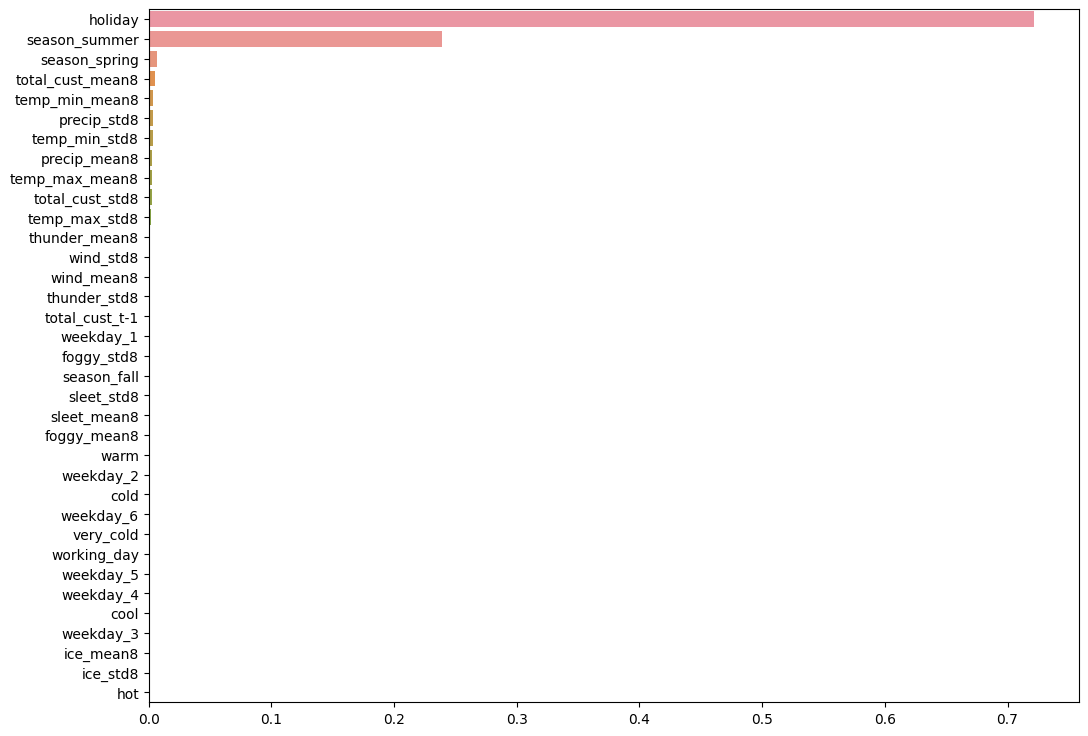

In [110]:
# plot feature importance
plt.figure(figsize=[12,9])
importances = list(pipeline_ada_tuned.steps[1][1].feature_importances_)

imp_dict = {key: val for key, val in zip(list(X.columns), importances)}
sorted_feats = sorted(imp_dict.items(), key=lambda x:x[1], reverse=True)
x_val = [x[0] for x in sorted_feats]
y_val = [x[1] for x in sorted_feats]

#importances.sort(reverse=True)
sb.barplot(x = y_val,y = x_val)
#importances



### Running AdaBoost with differenced y

In [111]:
# get the final scores for the differenced data
split = 10
all_scores_test = []
all_scores_train = []

for i in range(split):
    scores_test = split_predict_test(X_train_over, y_train_over, X_test_over, y_test_over, i)
    all_scores_test.append(scores_test)
    scores_train = split_predict_train(X_train_over, y_train_over, X_test_over, y_test_over, i)
    all_scores_train.append(scores_train)
    
rmse_test = []
rmsle_test = []
mae_test = []
rmse_train = []
rmsle_train = []
mae_train = []

for vals in all_scores_test:
    rmse_test.append(vals[0])
    rmsle_test.append(vals[1])
    mae_test.append(vals[2])
    
for vals in all_scores_train:
    rmse_train.append(vals[0])
    rmsle_train.append(vals[1])
    mae_train.append(vals[2])
    
print('Overall Test RMSE:', sum(rmse_test)/split)
print('Overall Test RMSLE:', sum(rmsle_test)/split)
print('Overall Test MAE:', sum(mae_test)/split)

print('Overall Train RMSE:', sum(rmse_train)/split)
print('Overall Train RMSLE:', sum(rmsle_train)/split)
print('Overall Train MAE:', sum(mae_train)/split)

Overall Test RMSE: 2024.5278191861184
Overall Test RMSLE: 0.36882319379629736
Overall Test MAE: 1475.29500010589
Overall Train RMSE: 1317.0231546244502
Overall Train RMSLE: 0.3078636091577259
Overall Train MAE: 912.6397927984219


In [112]:
# check how the model performance without certain features that are very unimportant
X_feat_imp = X.drop(columns=['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'])

# creating and fitting the ML pipeline
trend_features = ['total_cust_mean'+str(window), 'total_cust_std'+str(window)]#, 'total_cust_t-1']
preprocessor = ColumnTransformer([('trend_diff', FunctionTransformer(np.log1p, validate=False),
                                trend_features),], remainder='passthrough')
pipeline = Pipeline([('preprocessor', preprocessor),('model', model_ada_tuned)])
pipeline_ada_tuned = pipeline.fit(X_feat_imp, y)

# creating a timeseries split of the datasets
time_split = TimeSeriesSplit(n_splits=10)

# doing cross validation on the chunks of data and calculating scores
scores_ada_tuned = cross_validate(pipeline_ada_tuned, X_feat_imp, y, cv=time_split,
                         scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_squared_log_error'],
                         return_train_score=True, n_jobs=-1)

# root mean squared error
print('AdaBoost: Average RMSE train data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_error']])/
                        len(scores_ada_tuned['train_neg_mean_squared_error']))
print('AdaBoost: Average RMSE test data:', 
      sum([np.sqrt(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_error']])/
                        len(scores_ada_tuned['test_neg_mean_squared_error']))

# mean average error
print('AdaBoost: Average MAE train data:', 
      sum([(-1 * x) for x in scores_ada_tuned['train_neg_mean_absolute_error']])/
                        len(scores_ada_tuned['train_neg_mean_absolute_error']))
print('AdaBoost: Average MAE test data:', 
      sum([(-1 * x) for x in scores_ada_tuned['test_neg_mean_absolute_error']])/
                        len(scores_ada_tuned['test_neg_mean_absolute_error']))

# root mean squared log error
print('AdaBoost: Average RMSLE train data:', 
      sum([(-1 * x) for x in scores_ada_tuned['train_neg_mean_squared_log_error']])/
                        len(scores_ada_tuned['train_neg_mean_squared_log_error']))
print('AdaBoost: Average RMSLE test data:', 
      sum([(-1 * x) for x in scores_ada_tuned['test_neg_mean_squared_log_error']])/
                        len(scores_ada_tuned['test_neg_mean_squared_log_error']))

AdaBoost: Average RMSE train data: 1089.9334497395976
AdaBoost: Average RMSE test data: 2035.9323458409417
AdaBoost: Average MAE train data: 771.656977495503
AdaBoost: Average MAE test data: 1599.328457108129
AdaBoost: Average RMSLE train data: 0.0928447172643879
AdaBoost: Average RMSLE test data: 0.14160841308361777


## 4.3 XGBoost